In [1]:
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde, norm
from astropy.table import Table, vstack

from matplotlib import transforms
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")

import mcmc_binarity

# Estimating the unresolved binary fraction in nearby open clusters

This Jupyter notebook shows how to use MCMC in conjunction with a custom mixture model to estimate the unresolved binary fraction in open clusters (given a clean membership list of main-sequence members).

The main functions used are implemented in mcmc_binarity.py.

### Read cluster-member data from the Gaia EDR3 catalogue of Tarricq+2022

The data are stored in a sub-folder of the repository, one ascii file per cluster.

In [2]:
tarricqdir = "data/Tarricq_selected_members_OCs/"
files = os.listdir(tarricqdir)
print(len(files), "OCs selected")

251 OCs selected


### Run the MCMC analysis for 1 cluster (Figure 3)

In [3]:
clusname = "Alessi_1"

Alessi_1 : 46 stars
Maximum likelihood result: [ -21.64258729  136.36487584 -208.77123381  148.82955993  -38.07563126
   -5.38324712    3.02247179]
Running MCMC...


100%|██████████| 8000/8000 [05:44<00:00, 23.19it/s]


Multiprocessing took 345.0 seconds
Mean acceptance fraction: 0.36


<Figure size 432x288 with 0 Axes>

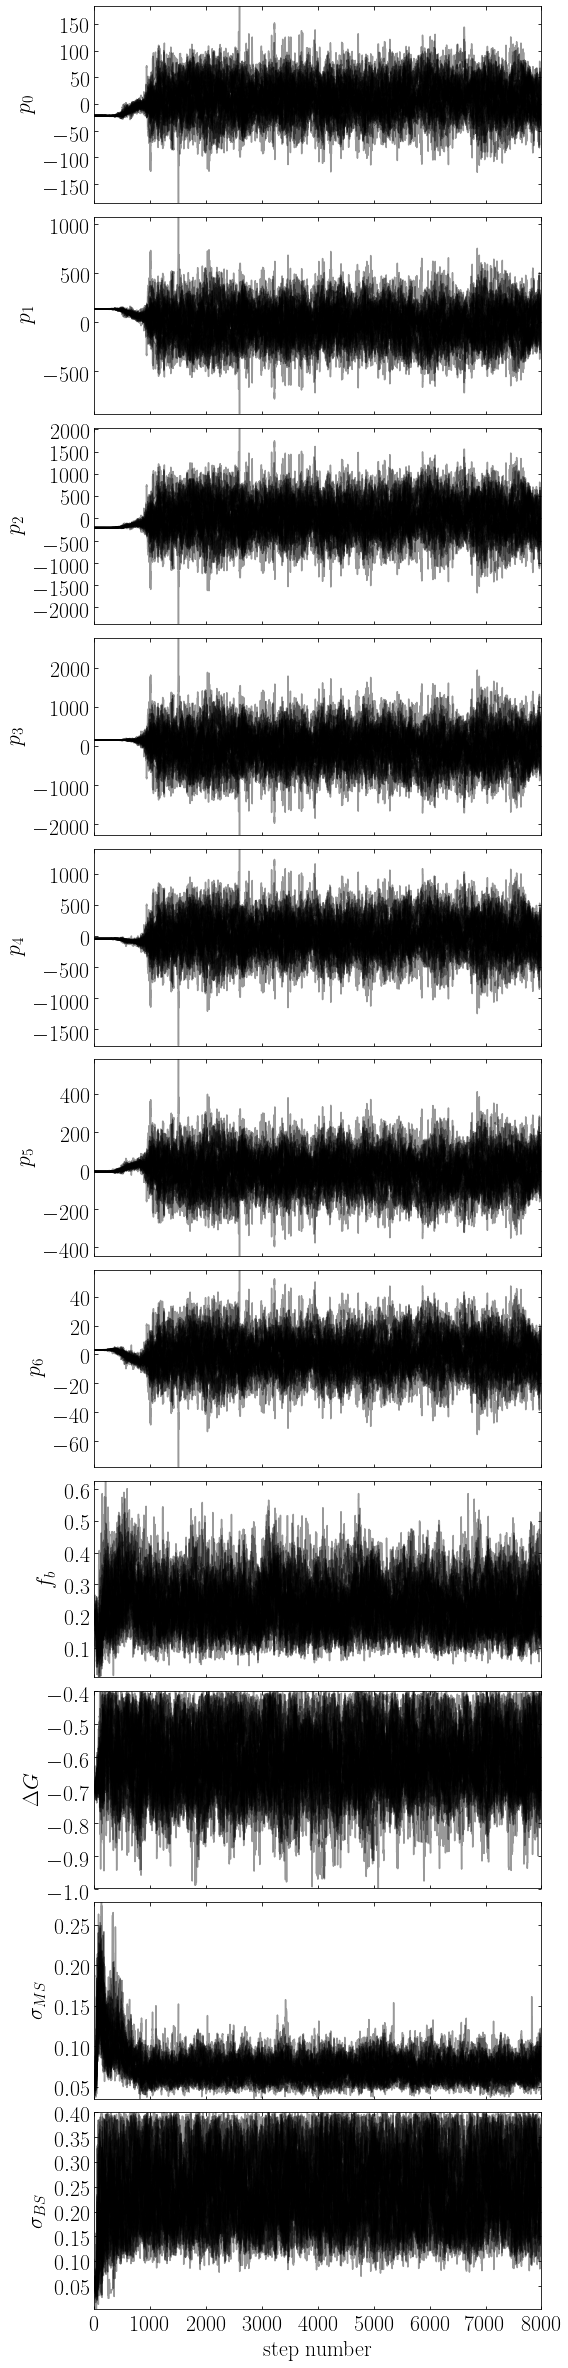

In [4]:
import time
import emcee
import corner
from multiprocessing import Pool

t = Table.read(tarricqdir + clusname + "_sel_MS_members_Tarricq.txt", format="ascii")
x    = t["bp_rp"]
xerr = t["bp_rp_error"]
y    = t["phot_g_mean_mag"]
yerr = t["phot_g_mean_mag_error"]

print(clusname, ":", len(t), "stars")

# Initial guess for a MaxLikelihood fit
theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)

# Set up the MCMC sampler
nwalkers=32
nsteps=8000
burnin=3000
ndim = len(theta0)
pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

print("Running MCMC...")
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob3, args=(x, y, xerr, yerr), pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

acc_frac = np.mean(sampler.acceptance_fraction)
print("Mean acceptance fraction: {0:.2f}".format(acc_frac))

# Get the marginalised fit parameters
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                np.round(v[2]-v[1],3), 
                                                                np.round(v[1]-v[0],3)), 
                                                     zip(*np.percentile(samples, [16, 50, 84], axis=0)))
# MCMC iteration plot
plt.clf()
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 3*ndim))
poly_labels    = ["$p_0$", "$p_1$", "$p_2$", "$p_3$", "$p_4$", "$p_5$", "$p_6$", "$p_7$", "$p_8$"]
mixture_labels = ["$f_b$","$\Delta G$", "$\sigma_{MS}$", "$\sigma_{BS}$"]
labels         = poly_labels[:(ndim-4)] + mixture_labels
for ii in np.arange(ndim):
    axes[ii].plot(sampler.chain[:, :, ii].T, color="k", alpha=0.4)
    axes[ii].set_ylabel(labels[ii])
axes[ndim-1].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)

Text(0.5, 0.98, 'Alessi 1')

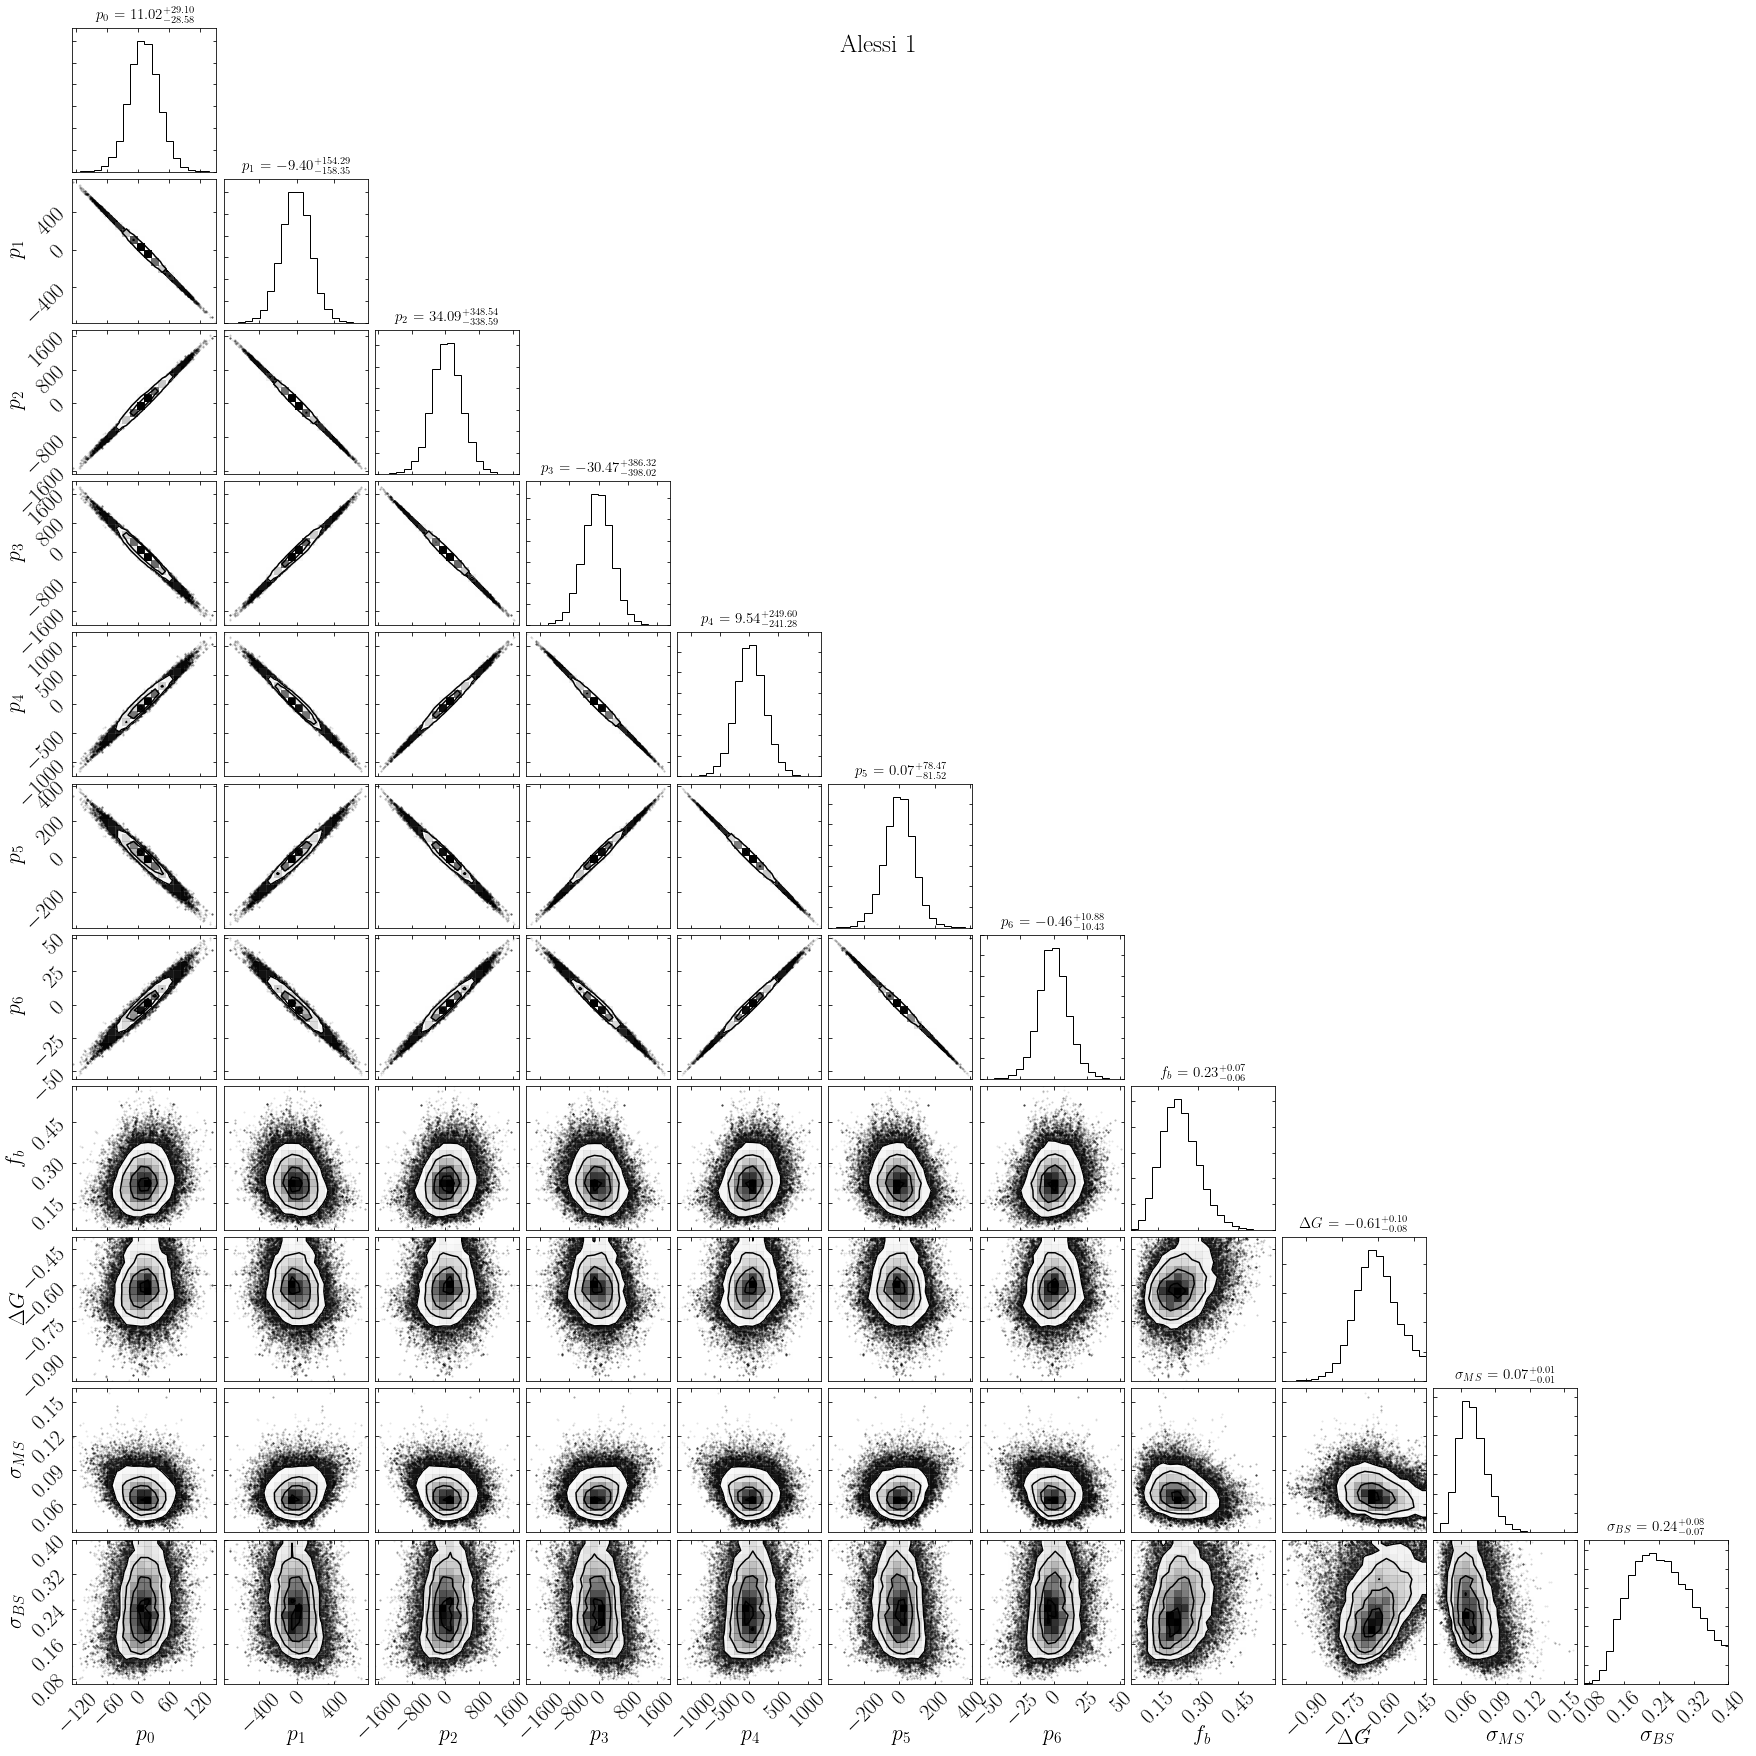

In [5]:
# Corner plot
fig = corner.corner(samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 15})
plt.suptitle(clusname.replace("_", " "), fontsize=25)

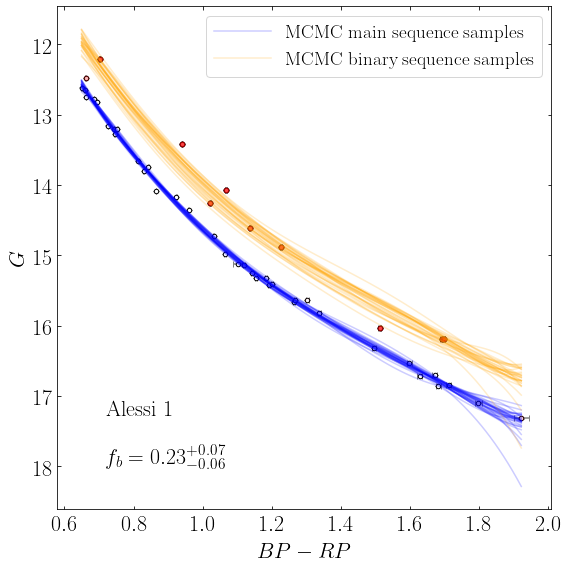

In [6]:
# CMD plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
plt.scatter(x,y, label=None, c="w")
xarr = np.linspace(np.min(x),np.max(x),100)
# Plot the maximum likelihood result.
polynom = np.poly1d(theta0[:-4][::-1])
fb_simple=[]
#plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
# Plot some MCMC samples onto the data.
for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
    bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
    plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
    binaries = (y < ms(x) - 3 * sM)
    fb_simple.append(np.sum(binaries)/len(x))
    plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
# Plot the best-parameter result.
#polynom = np.poly1d([p6_m[0],p5_m[0],p4_m[0],p3_m[0],p2_m[0],p1_m[0],p0_m[0]])
plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
plt.xlabel(r"$BP-RP$", fontsize=22)
plt.ylabel(r"$G$", fontsize=22)
plt.legend(loc="upper right", fontsize=19)
# Annotate name of the cluster and binary fraction
ax = plt.gca()
plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, fontsize=22)
plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("im_mcmc/im_mcmc_tarricq/cmd_fit_mcmc_"+ clusname +".png")

### Now do the polynomial test suggested by the referee

The referee suggested that, once we have a good fit to the single-star sequence, we should just use a cut in the CMD to define which stars are binaries and which not.

In this example, we take the best fitting polynomial and cut $3 \sigma_{SS}$ above the single-star sequence:

In [7]:
fb_simple=[]
for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    binaries = (y < ms(x) - 3 * sM)
    fb_simple.append(np.sum(binaries)/len(x))
fb_simple = np.percentile(np.array(fb_simple), [16, 50, 84])

Text(0.1, 0.1, '$f_b^{\\rm referee}={0.20}^{+-0.00}_{-0.02}$')

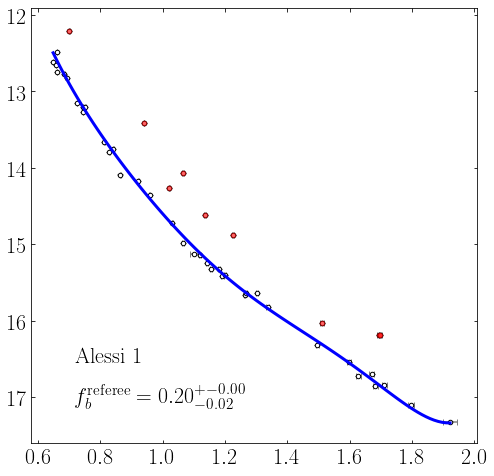

In [8]:
# CMD plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
plt.scatter(x,y, label=None, c="w")
# Overplot the 2 Gaussians
#plt.plot(kdearr, norm.pdf(kdearr, loc=0., scale=), c="k", lw=3, alpha=1)
plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.6)
plt.plot(xarr, ms(xarr), color="b", lw=3)
ax = plt.gca()
ax.invert_yaxis()
plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, fontsize=22)
plt.text(0.1, 0.1, r"$f_b^{{\rm referee}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)


### Histogram of $\Delta G_i$

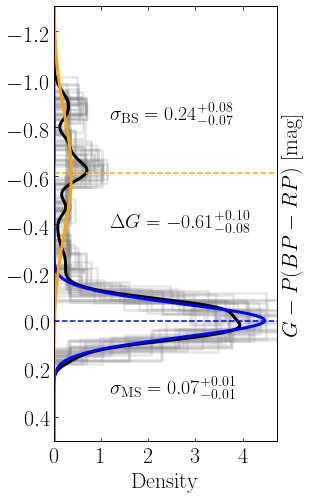

In [9]:
plt.figure(figsize=(4,8))
ax = plt.subplot(111)
# first of all, the base transformation of the data points is needed
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)

edges = [-1.3,.5]

kdearr = np.linspace(edges[0], edges[1],1000)
kderes = np.zeros(1000)

for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    # Compute Delta G_i
    DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
    vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                   label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                   color="grey", transform= rot + base)
    kde = gaussian_kde(y - ms(x), bw_method=.1)
    kderes = kderes + kde.evaluate(kdearr)
plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)

# Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)

ax.axhline(0.,      c="b", ls="dashed")
ax.axhline(DG_m[0], c="orange", ls="dashed")

# Beautify the plot
ax2 = ax.twinx() 
ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
ax.set_xlabel(r"Density") 
ax2.set_xlim(0, 1.2*np.max(kderes/30)) 
ax2.set_yticks([]) 
ax.set_ylim(edges[1], edges[0]) 


plt.text(0.25, 0.12, r"$\sigma_{{\rm MS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sM_m[0],sM_m[1],sM_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.text(0.25, 0.5, r"$\Delta G={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(DG_m[0],DG_m[1],DG_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sB_m[0],sB_m[1],sB_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.savefig("./im_mcmc/im_mcmc_tarricq/cmd_fit_residuals_" + clusname + ".png")

### Reproduce Fig. 4 (using the precomputed results)

These are the clusters that we want to plot:

In [79]:
fig4_list = ["Blanco_1", "UPK_587", "Stock_1", "UBC_582", "Gulliver_6", "IC_1396"]

Let's define some convenient plotting routines:

In [91]:
def cmd_plot(clusname, x, y, xerr, yerr, samples, results):
    # CMD plot
    plt.figure(figsize=(8,8))
    plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
    plt.scatter(x,y, label=None, c="w")
    xarr = np.linspace(np.min(x),np.max(x),100)
    fb_simple=[]
    # Plot some MCMC samples onto the data.
    for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
        ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
        plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
        bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
        plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
        binaries = (y < ms(x) - 3 * sM)
        fb_simple.append(np.sum(binaries)/len(x))
        plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
    plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
    plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
    plt.xlabel(r"$BP-RP$", fontsize=22)
    plt.ylabel(r"$G$", fontsize=22)
    plt.legend(loc="upper right", fontsize=19)
    # Annotate name of the cluster and binary fraction
    ax = plt.gca()
    plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
             verticalalignment='center', transform=ax.transAxes, fontsize=22)
    plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(results["fb_50"][0],results["fb_sigu"][0],results["fb_sigl"][0]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
    ax.invert_yaxis()
    # If fit quality is bad, mark background 
    if abs(results["DG_50"][0] + 0.75) > 0.1 or results["sB_50"][0] > 0.25 or results["sM_50"][0] > 0.2:
        ax.set_facecolor("mistyrose")
    plt.tight_layout()
    plt.savefig("im_mcmc/im_mcmc_tarricq/cmd_fit_mcmc_"+ clusname +".png")
    
def cmd_residuals_plot(clusname, samples, results):
    plt.figure(figsize=(4,8))
    ax = plt.subplot(111)
    # first of all, the base transformation of the data points is needed
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg(-90)

    edges = [-1.3,.5]

    kdearr = np.linspace(edges[0], edges[1],1000)
    kderes = np.zeros(1000)

    for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
        ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
        # Compute Delta G_i
        DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
        vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                       label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                       color="grey", transform= rot + base)
        kde = gaussian_kde(y - ms(x), bw_method=.1)
        kderes = kderes + kde.evaluate(kdearr)
    plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)

    # Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
    plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
    plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)

    ax.axhline(0.,      c="b", ls="dashed")
    ax.axhline(DG_m[0], c="orange", ls="dashed")

    # Beautify the plot
    ax2 = ax.twinx() 
    ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
    ax.set_xlabel(r"Density") 
    ax2.set_xlim(0, np.max([1.2*np.max(kderes/30), 5.])) 
    ax2.set_yticks([]) 
    ax.set_ylim(edges[1], edges[0]) 

    if abs(results["DG_50"][0] + 0.75) > 0.1 or results["sB_50"][0] > 0.25 or results["sM_50"][0] > 0.2:
        ax.set_facecolor("mistyrose")

    plt.text(0.25, 0.12, r"$\sigma_{{\rm MS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(results["sM_50"][0],results["sM_sigu"][0],results["sM_sigl"][0]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
    plt.text(0.25, 0.5, r"$\Delta G={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(results["DG_50"][0],results["DG_sigu"][0],results["DG_sigl"][0]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
    plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(results["sB_50"][0],results["sB_sigu"][0],results["sB_sigl"][0]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
    plt.savefig("./im_mcmc/im_mcmc_tarricq/cmd_fit_residuals_" + clusname + ".png")

And finally, create a loop that does the magic for us:

Blanco_1
UPK_587
Stock_1
UBC_582
Gulliver_6
IC_1396


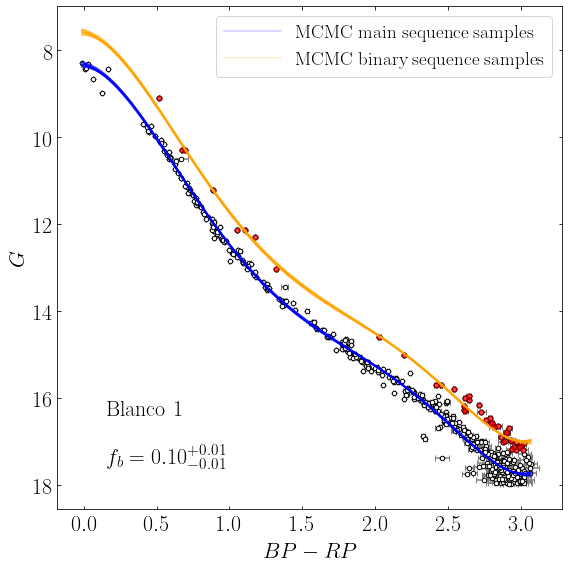

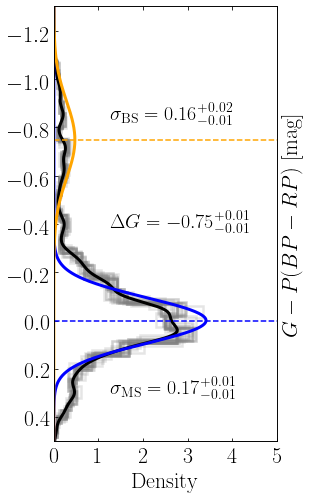

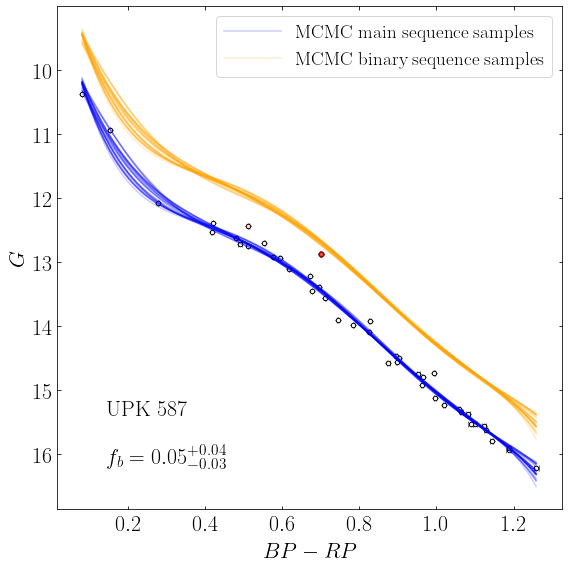

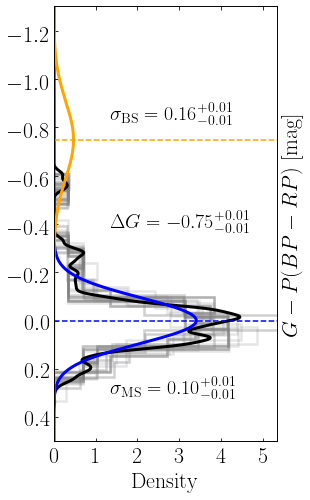

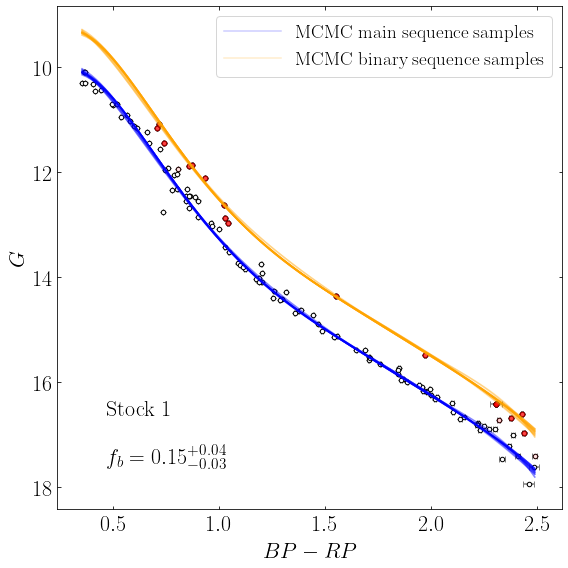

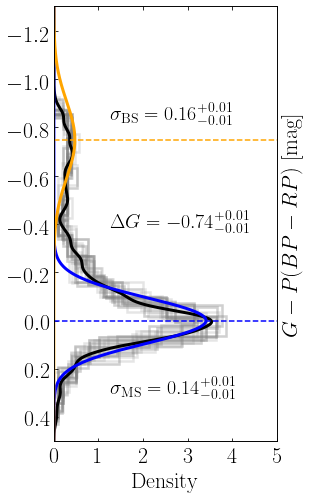

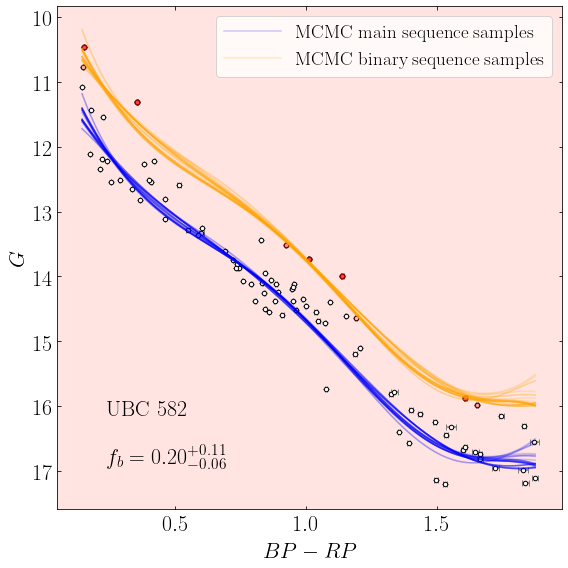

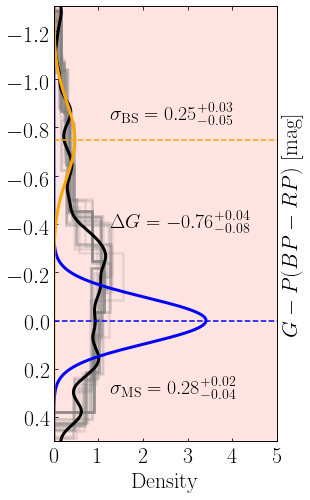

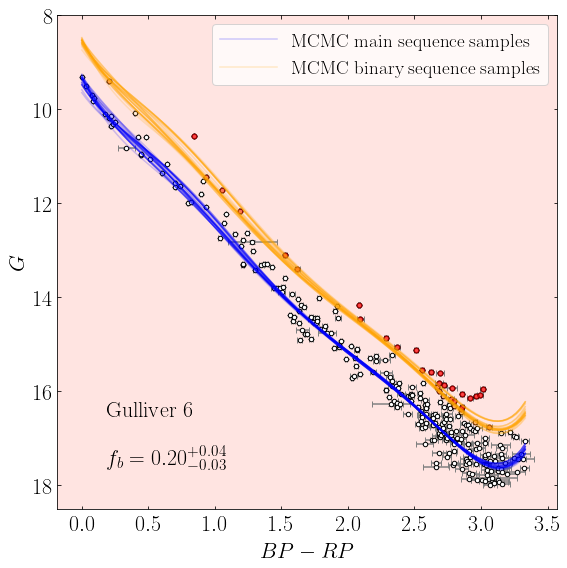

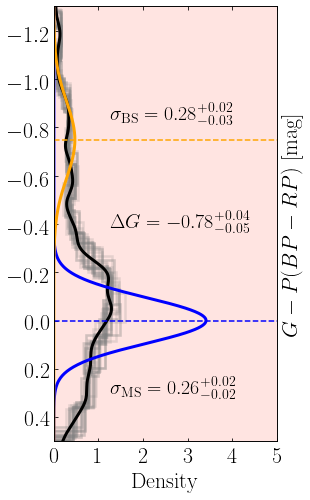

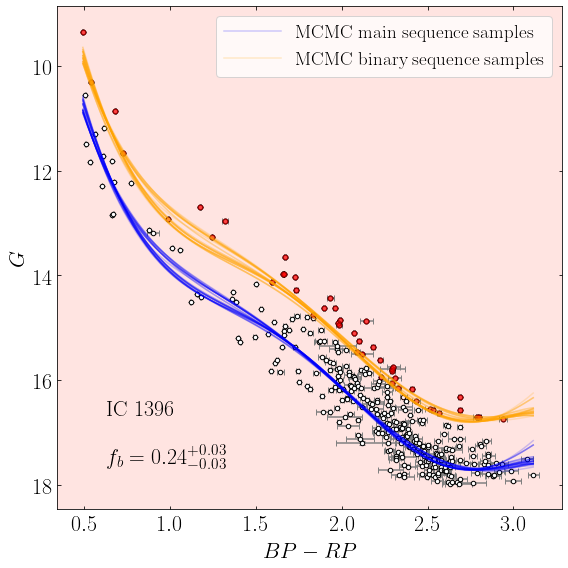

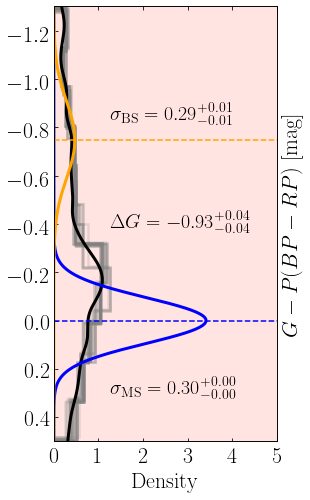

In [92]:
tarricqres = Table.read("data/mcmc_results_tarricq_summary.fits")
cantatres  = Table.read("data/mcmc_results_cantat_summary.fits")
tarricqdir = "data/Tarricq_selected_members_OCs/"
cantatdir  = "data/Cantat_selected_members_OCs_younger50Myr/"

for clusname in fig4_list:
    print(clusname)
    # Load data (main-sequence member tables and overall MCMC results)
    if clusname + "_sel_MS_members_Tarricq.txt" in os.listdir(tarricqdir):
        t = Table.read(tarricqdir + clusname + "_sel_MS_members_Tarricq.txt", format="ascii")
        x    = t["bp_rp"]
        xerr = t["bp_rp_error"]
        y    = t["phot_g_mean_mag"]
        yerr = t["phot_g_mean_mag_error"]
        results = tarricqres[ tarricqres["clus"]==clusname ]
    elif clusname + "_sel_MS_members_Cantat.txt" in os.listdir(cantatdir):
        t = Table.read(cantatdir + clusname + "_sel_MS_members_Cantat.txt", format="ascii")
        x    = t["BP-RP"]
        xerr = np.sqrt((2.5 * np.log10(1 + 1./t["phot_bp_mean_flux_over_error"]))**2 +
                       (2.5 * np.log10(1 + 1./t["phot_rp_mean_flux_over_error"]))**2)
        y    = t["Gmag"]
        yerr = 2.5 * np.log10(1 + 1./t["phot_g_mean_flux_over_error"])
        results = cantatres[ cantatres["clus"]==clusname ]
    else:
        raise ValueError("I don't have this cluster in the database:(")
    # Load MCMC samples
    samples = np.load("data/results_mcmc_samples/samples_mcmc_" + clusname + ".npz")["samples"]
    # Do the plot
    cmd_plot(clusname, x, y, xerr, yerr, samples, results)
    cmd_residuals_plot(clusname, samples, results)

### Do the analysis for all the Tarricq+2022 OCs

In [63]:
plotdir="./im_mcmc/test/"

In [66]:
for ii in np.arange(len(files)):
    t = Table.read(tarricqdir + files[ii], format="ascii")
    x    = t["bp_rp"]
    xerr = t["bp_rp_error"]
    y    = t["phot_g_mean_mag"]
    yerr = t["phot_g_mean_mag_error"]
    clusname = files[ii][:-27]

    print(clusname, ":", len(t), "stars")

    # Initial guess for ML fit
    theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
    Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
    theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)
    # Set up the MCMC sampler
    nwalkers=32
    nsteps=15000
    burnin=2000
    ndim = len(theta0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    print("Running MCMC...")
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
        start = time.time()
        sampler.run_mcmc(pos, nsteps, progress=True)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))

    acc_frac = np.mean(sampler.acceptance_fraction)
    print("Mean acceptance fraction: {0:.2f}".format(acc_frac))
    
    if acc_frac > 0.05:
        # Get the marginalised fit parameters
        samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                        np.round(v[2]-v[1],3), 
                                                                        np.round(v[1]-v[0],3)), 
                                                             zip(*np.percentile(samples, [16, 50, 84], axis=0)))

        # CMD plot
        plt.figure(figsize=(8,8))
        plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
        plt.scatter(x,y, label=None, c="w")
        xarr = np.linspace(np.min(x),np.max(x),100)
        # Plot the maximum likelihood result.
        polynom = np.poly1d(theta0[:-4][::-1])
        plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
        # Plot some MCMC samples onto the data.
        fb_simple=[]
        for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=25)]:
            ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
            plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
            bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
            plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
            binaries = (y < ms(x) - 3 * sM)
            fb_simple.append(np.sum(binaries)/len(x))
            plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
        fb_simple = np.percentile(np.array(fb_simple), [16, 50, 84])    
        # Plot the best-parameter result.
        plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
        plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
        plt.xlabel(r"$BP-RP$", fontsize=22)
        plt.ylabel(r"$G$", fontsize=22)
        plt.legend(loc="upper right", fontsize=19)
        # Annotate name of the cluster and binary fraction
        ax = plt.gca()
        plt.text(0.1, 0.3, clusname.replace("_", " "), horizontalalignment='left',
                 verticalalignment='center', transform=ax.transAxes, fontsize=22)
        plt.text(0.1, 0.2, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
        plt.text(0.1, 0.1, r"$f_b^{{\rm referee}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
        ax.invert_yaxis()
        plt.tight_layout()
        
        plt.savefig(plotdir+"cmd_fit_mcmc_"+clusname+".png")
        plt.close()

        #  save / return the results as a one-row astropy table
        result = Table(names=('clus', 'nb_MS_members', 'MS_width', 'nsteps', 'burnin', 'acc_frac', 
                         'fb_ref_50', 'fb_ref_sigu', 'fb_ref_sigl', 'fb_50', 'fb_sigu', 'fb_sigl', 
                         'DG_50', 'DG_sigu', 'DG_sigl', 
                         'sM_50', 'sM_sigu', 'sM_sigl', 'sB_50', 'sB_sigu', 'sB_sigl'), 
                  dtype=('S20', 'i4', 'f4', 'i4', 'i4', 'f4', 'f4', 'f4', 'f4', 
                         'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))
        result.add_row((clusname, len(x), np.max(x)-np.min(x), nsteps, burnin, np.round(acc_frac,2), 
                   fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1],
                   fb_m[0], fb_m[1], fb_m[2], DG_m[0], DG_m[1], DG_m[2], 
                   sM_m[0], sM_m[1], sM_m[2], sB_m[0], sB_m[1], sB_m[2]))        
        # Save the results
        if ii == 0:
            restable = result
        else:
            if result == None:
                pass
            else:
                restable = vstack([restable, result])
        restable.write("data/mcmc_results_tarricq_summary_refereetest.fits", overwrite=True)
        

NGC_2539 : 418 stars
Maximum likelihood result: [  12.93948264    1.23912693  -28.06473138  101.92071616 -129.49545761
   72.74222775  -15.38656731]
Running MCMC...


100%|██████████| 5000/5000 [04:02<00:00, 20.60it/s]


Multiprocessing took 242.8 seconds
Mean acceptance fraction: 0.40
Melotte_22 : 1158 stars
Maximum likelihood result: [ 6.96218491  3.12858113 -0.28563707  3.05922272 -2.87269688  0.94208868
 -0.1043249 ]
Running MCMC...


100%|██████████| 5000/5000 [04:38<00:00, 17.99it/s]


Multiprocessing took 278.1 seconds
Mean acceptance fraction: 0.40
UPK_90 : 47 stars
Maximum likelihood result: [-2.42943713e-01  7.96579234e+01 -2.33114028e+02  3.78413264e+02
 -3.35108059e+02  1.51463497e+02 -2.71663865e+01]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.24it/s]


Multiprocessing took 215.2 seconds
Mean acceptance fraction: 0.31
NGC_6633 : 265 stars
Maximum likelihood result: [  -6.10936398   78.83440438 -156.43122434  168.14620662  -96.30551636
   27.76492034   -3.16502464]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 21.97it/s]


Multiprocessing took 227.7 seconds
Mean acceptance fraction: 0.40
Mamajek_4 : 255 stars
Maximum likelihood result: [  7.72050548  12.78243629 -25.66859015  38.21273996 -28.00677026
   9.65874058  -1.26269496]
Running MCMC...


100%|██████████| 5000/5000 [03:51<00:00, 21.63it/s]


Multiprocessing took 231.2 seconds
Mean acceptance fraction: 0.40
Trumpler_18 : 87 stars
Maximum likelihood result: [   31.40186171  -182.91362687   659.85502515 -1132.67922034
  1006.2654691   -442.01046664    74.99640852]
Running MCMC...


100%|██████████| 5000/5000 [03:29<00:00, 23.91it/s]


Multiprocessing took 209.2 seconds
Mean acceptance fraction: 0.37
UBC_183 : 45 stars
Maximum likelihood result: [  11.40723261  -17.2935243   132.0156507  -325.15664153  378.49919882
 -209.10215676   44.29871162]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.62it/s]


Multiprocessing took 221.1 seconds
Mean acceptance fraction: 0.37
COIN-Gaia_8 : 96 stars
Maximum likelihood result: [  5.62157549  33.49651127 -69.507481    70.43839385 -27.95532403
   0.62321253   1.36830268]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.47it/s]


Multiprocessing took 222.5 seconds
Mean acceptance fraction: 0.39
ASCC_58 : 238 stars
Maximum likelihood result: [  9.7022096    5.69499499 -12.68147763  23.48727354 -17.92251358
   6.00026197  -0.73765166]
Running MCMC...


100%|██████████| 5000/5000 [03:59<00:00, 20.91it/s]


Multiprocessing took 239.1 seconds
Mean acceptance fraction: 0.40
Stock_1 : 119 stars
Maximum likelihood result: [ 9.32844837  1.78181853 -0.16219366  7.58834737 -8.32285593  3.30090899
 -0.45670089]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.36it/s]


Multiprocessing took 223.6 seconds
Mean acceptance fraction: 0.40
NGC_1582 : 133 stars
Maximum likelihood result: [ -18.28767309  205.39556503 -567.08246919  817.63491768 -641.64864533
  261.05794075  -43.12341512]
Running MCMC...


100%|██████████| 5000/5000 [03:20<00:00, 24.91it/s]


Multiprocessing took 200.8 seconds
Mean acceptance fraction: 0.34
NGC_2670 : 124 stars
Maximum likelihood result: [  41.38422027 -150.56103     268.9205195  -166.41794717  -27.87242397
   69.23921158  -19.95056675]
Running MCMC...


100%|██████████| 5000/5000 [03:19<00:00, 25.04it/s]


Multiprocessing took 199.7 seconds
Mean acceptance fraction: 0.35
Alessi_31 : 146 stars
Maximum likelihood result: [ -287.24941038  1150.56343014 -1827.89766353  1532.48176065
  -712.91067075   174.55575158   -17.58365344]
Running MCMC...


100%|██████████| 5000/5000 [03:06<00:00, 26.80it/s]


Multiprocessing took 186.6 seconds
Mean acceptance fraction: 0.33
LP_2220 : 117 stars
Maximum likelihood result: [   28.0509012   -202.3589071    797.18431872 -1428.55517881
  1310.34173156  -597.0671236    107.14219789]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.51it/s]


Multiprocessing took 222.2 seconds
Mean acceptance fraction: 0.36
UPK_442 : 44 stars
Maximum likelihood result: [  7.8892545   21.56360906 -48.94299999  56.45312841 -26.49732218
   2.84956478   0.67063975]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.21it/s]


Multiprocessing took 215.5 seconds
Mean acceptance fraction: 0.38
UPK_545 : 214 stars
Maximum likelihood result: [ 9.54213519 -2.97809214 13.45977952 -7.99815555  0.49961043  0.76338699
 -0.15720675]
Running MCMC...


100%|██████████| 5000/5000 [03:51<00:00, 21.63it/s]


Multiprocessing took 231.3 seconds
Mean acceptance fraction: 0.40
UPK_4 : 92 stars
Maximum likelihood result: [  158.52434964  -868.88802277  2054.62090019 -2484.94188196
  1625.5833255   -544.05388427    72.56149304]
Running MCMC...


100%|██████████| 5000/5000 [03:26<00:00, 24.17it/s]


Multiprocessing took 206.9 seconds
Mean acceptance fraction: 0.33
Alessi_3 : 98 stars
Maximum likelihood result: [ 10.72111985 -15.93541484  48.8546529  -51.35344096  26.51972665
  -6.71587713   0.66745422]
Running MCMC...


100%|██████████| 5000/5000 [03:55<00:00, 21.23it/s]


Multiprocessing took 235.6 seconds
Mean acceptance fraction: 0.40
NGC_6709 : 256 stars
Maximum likelihood result: [  11.03298105  -12.32956062   77.95284834 -150.27238732  137.77334365
  -59.63596475    9.7540916 ]
Running MCMC...


100%|██████████| 5000/5000 [04:10<00:00, 19.96it/s]


Multiprocessing took 250.5 seconds
Mean acceptance fraction: 0.38
UPK_24 : 140 stars
Maximum likelihood result: [ -24.51745761  180.75576375 -365.00907046  375.46177727 -204.94735793
   56.78646498   -6.2893969 ]
Running MCMC...


100%|██████████| 5000/5000 [03:46<00:00, 22.11it/s]


Multiprocessing took 226.2 seconds
Mean acceptance fraction: 0.34
Alessi_Teutsch_11 : 100 stars
Maximum likelihood result: [   4.75578981   49.65553779 -143.18608222  211.39978991 -157.39735952
   57.17000807   -8.06408685]
Running MCMC...


100%|██████████| 5000/5000 [04:07<00:00, 20.17it/s]


Multiprocessing took 247.9 seconds
Mean acceptance fraction: 0.39
UPK_508 : 33 stars
Maximum likelihood result: [   35.42186879  -262.16065254  1036.16227065 -1966.22892396
  1949.71177587  -968.45322767   189.93796047]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.39it/s]


Multiprocessing took 223.3 seconds
Mean acceptance fraction: 0.22
NGC_2516 : 1791 stars
Maximum likelihood result: [  8.28853999  11.05404124 -23.52956412  34.11680297 -23.20870381
   7.30605895  -0.86544969]
Running MCMC...


100%|██████████| 5000/5000 [04:08<00:00, 20.13it/s]


Multiprocessing took 248.4 seconds
Mean acceptance fraction: 0.28
Ruprecht_91 : 180 stars
Maximum likelihood result: [ 10.45776386  15.85989128 -48.87277662  74.23474317 -44.01843924
   5.79715289   1.85866849]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.30it/s]


Multiprocessing took 224.2 seconds
Mean acceptance fraction: 0.40
UPK_552 : 45 stars
Maximum likelihood result: [ 8.67867133  3.99219907 -3.82171991 10.87056642 -9.94660894  3.66416826
 -0.4779668 ]
Running MCMC...


100%|██████████| 5000/5000 [03:32<00:00, 23.54it/s]


Multiprocessing took 212.5 seconds
Mean acceptance fraction: 0.33
NGC_2925 : 154 stars
Maximum likelihood result: [  9.66375538  15.65780804 -52.73655256  97.46710383 -84.62881073
  34.66180099  -5.43173266]
Running MCMC...


100%|██████████| 5000/5000 [03:48<00:00, 21.92it/s]


Multiprocessing took 228.1 seconds
Mean acceptance fraction: 0.40
NGC_6997 : 256 stars
Maximum likelihood result: [ -426.45214038  1572.7676539  -2294.48115323  1741.48509337
  -723.00387814   155.76556518   -13.6324583 ]
Running MCMC...


100%|██████████| 5000/5000 [03:21<00:00, 24.80it/s]


Multiprocessing took 201.7 seconds
Mean acceptance fraction: 0.26
UPK_265 : 73 stars
Maximum likelihood result: [  50.46035657 -193.08101498  386.87016511 -395.15611266  220.30108298
  -63.61048909    7.44476793]
Running MCMC...


100%|██████████| 5000/5000 [03:05<00:00, 26.95it/s]


Multiprocessing took 185.6 seconds
Mean acceptance fraction: 0.31
NGC_2669 : 195 stars
Maximum likelihood result: [   1.84297909   86.14364854 -285.59086264  490.55768318 -448.68250281
  210.38390202  -39.84020483]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.60it/s]


Multiprocessing took 221.3 seconds
Mean acceptance fraction: 0.39
NGC_2448 : 114 stars
Maximum likelihood result: [ 11.63015244   2.31660262   9.01324448 -39.43204653  74.97063605
 -59.04238691  16.30109763]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.17it/s]


Multiprocessing took 225.6 seconds
Mean acceptance fraction: 0.40
NGC_2168 : 1243 stars
Maximum likelihood result: [  9.95249572   8.02632021 -11.33151002  10.91643873  -2.65807918
  -1.02273886   0.38701042]
Running MCMC...


100%|██████████| 5000/5000 [03:59<00:00, 20.89it/s]


Multiprocessing took 239.4 seconds
Mean acceptance fraction: 0.38
UBC_396 : 49 stars
Maximum likelihood result: [ -800.2696106   3559.56885095 -6512.80790174  6337.64860259
 -3440.53377366   984.56195794  -115.76610525]
Running MCMC...


100%|██████████| 5000/5000 [03:32<00:00, 23.51it/s]


Multiprocessing took 212.7 seconds
Mean acceptance fraction: 0.35
COIN-Gaia_38 : 102 stars
Maximum likelihood result: [  322.37791972 -1620.10941699  3449.86712402 -3819.43916249
  2318.87512795  -731.58114531    93.75825048]
Running MCMC...


100%|██████████| 5000/5000 [03:12<00:00, 25.97it/s]


Multiprocessing took 192.6 seconds
Mean acceptance fraction: 0.35
NGC_2910 : 132 stars
Maximum likelihood result: [   6.12751393   48.537029   -161.68113174  307.81120164 -322.4796553
  173.17861078  -36.79296774]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.35it/s]


Multiprocessing took 214.2 seconds
Mean acceptance fraction: 0.34
UPK_381 : 57 stars
Maximum likelihood result: [  -0.7565746    98.03107453 -312.11242915  501.65911473 -415.7016231
  171.24737469  -27.82675406]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.78it/s]


Multiprocessing took 219.5 seconds
Mean acceptance fraction: 0.38
NGC_6204 : 92 stars
Maximum likelihood result: [  3145.49912288 -20949.37371967  56908.81769147 -80436.98468485
  62443.40158048 -25263.23817417   4164.99407092]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.39it/s]


Multiprocessing took 213.8 seconds
Mean acceptance fraction: 0.30
Alessi_21 : 241 stars
Maximum likelihood result: [  9.5280538   10.44822297 -28.64749913  49.51754039 -38.18301876
  13.30509663  -1.7218653 ]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.27it/s]


Multiprocessing took 224.5 seconds
Mean acceptance fraction: 0.39
Alessi_Teutsch_3 : 98 stars
Maximum likelihood result: [   3.12839065   60.27287321 -165.76007332  230.83662808 -164.10344185
   57.63878642   -7.95081503]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.83it/s]


Multiprocessing took 219.1 seconds
Mean acceptance fraction: 0.40
Alessi_62 : 152 stars
Maximum likelihood result: [ -151.98456904   749.6356035  -1390.78633437  1338.33942995
  -700.6823262    189.47757537   -20.72597839]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.51it/s]


Multiprocessing took 222.2 seconds
Mean acceptance fraction: 0.39
NGC_5460 : 136 stars
Maximum likelihood result: [ 10.61487115  -1.79120686  26.12545037 -56.46508276  60.72596871
 -30.61271855   5.73780549]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.62it/s]


Multiprocessing took 221.1 seconds
Mean acceptance fraction: 0.40
NGC_2281 : 381 stars
Maximum likelihood result: [ 9.70403227 -0.30443226  9.58551691 -5.13907385 -1.27660207  1.61028118
 -0.32102786]
Running MCMC...


100%|██████████| 5000/5000 [03:48<00:00, 21.92it/s]


Multiprocessing took 228.2 seconds
Mean acceptance fraction: 0.40
Roslund_6 : 278 stars
Maximum likelihood result: [  8.91101015   4.94873852  -8.98829631  19.81395401 -16.76470595
   6.02765299  -0.7829956 ]
Running MCMC...


100%|██████████| 5000/5000 [03:48<00:00, 21.91it/s]


Multiprocessing took 228.2 seconds
Mean acceptance fraction: 0.40
UPK_31 : 84 stars
Maximum likelihood result: [  18.64849496  -45.42181204  107.93024429 -129.76708836   88.24924339
  -31.23599797    4.41357043]
Running MCMC...


100%|██████████| 5000/5000 [03:23<00:00, 24.58it/s]


Multiprocessing took 203.4 seconds
Mean acceptance fraction: 0.36
ASCC_111 : 83 stars
Maximum likelihood result: [   4.65558943   48.83974064 -129.00183364  172.52897084 -116.00973889
   38.01544058   -4.83084071]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.76it/s]


Multiprocessing took 219.8 seconds
Mean acceptance fraction: 0.38
NGC_7063 : 118 stars
Maximum likelihood result: [  9.22668422  17.00814245 -50.84577397  83.01410942 -64.2805231
  23.47266344  -3.26889361]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.89it/s]


Multiprocessing took 218.5 seconds
Mean acceptance fraction: 0.40
ASCC_41 : 112 stars
Maximum likelihood result: [ 9.23335774  0.79883324  4.26314841  0.30986514 -3.19124525  1.61773549
 -0.24169456]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.63it/s]


Multiprocessing took 221.0 seconds
Mean acceptance fraction: 0.38
Alessi_Teutsch_12 : 37 stars
Maximum likelihood result: [  17.88300844  -66.99857004  225.00989859 -350.73226579  290.53106534
 -121.98794267   20.32599605]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 23.02it/s]


Multiprocessing took 217.2 seconds
Mean acceptance fraction: 0.36
COIN-Gaia_5 : 33 stars
Maximum likelihood result: [  -3.65096695  127.89743189 -402.36318886  634.47817498 -525.82833105
  222.02541372  -37.97184783]
Running MCMC...


100%|██████████| 5000/5000 [03:28<00:00, 23.99it/s]


Multiprocessing took 208.5 seconds
Mean acceptance fraction: 0.33
Stock_23 : 64 stars
Maximum likelihood result: [  14.43314498  -37.58694096  128.73859011 -195.7415203   154.51515515
  -60.24953787    9.12244003]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.34it/s]


Multiprocessing took 214.3 seconds
Mean acceptance fraction: 0.37
UBC_260 : 104 stars
Maximum likelihood result: [  8.85630041  14.42809946 -41.02458754  69.88411735 -55.46881261
  20.33694162  -2.79927129]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.13it/s]


Multiprocessing took 216.2 seconds
Mean acceptance fraction: 0.39
UPK_230 : 61 stars
Maximum likelihood result: [  0.9864174   23.48458585   8.09756967 -60.49409845  62.50585643
 -25.59620966   3.7388514 ]
Running MCMC...


100%|██████████| 5000/5000 [03:18<00:00, 25.14it/s]


Multiprocessing took 199.0 seconds
Mean acceptance fraction: 0.35
NGC_6716 : 433 stars
Maximum likelihood result: [ 9.31262132  7.19849727 -3.47972973 -5.24193814 11.27726347 -6.5100392
  1.20574612]
Running MCMC...


100%|██████████| 5000/5000 [03:52<00:00, 21.54it/s]


Multiprocessing took 232.2 seconds
Mean acceptance fraction: 0.39
COIN-Gaia_11 : 131 stars
Maximum likelihood result: [ -67.59779107  205.11889213 -176.1189532    35.0321783    30.06419233
  -16.77990866    2.41440783]
Running MCMC...


100%|██████████| 5000/5000 [03:04<00:00, 27.08it/s]


Multiprocessing took 184.7 seconds
Mean acceptance fraction: 0.30
NGC_5822 : 437 stars
Maximum likelihood result: [  22.69811154  -62.14355085  127.98366842 -116.29094986   52.32359874
  -10.47128796    0.54236777]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.95it/s]


Multiprocessing took 217.9 seconds
Mean acceptance fraction: 0.35
UBC_199 : 45 stars
Maximum likelihood result: [-1355.2624526   5293.66560696 -8354.9112772   6883.62571702
 -3120.13983247   738.15822601   -71.33042108]
Running MCMC...


100%|██████████| 5000/5000 [03:09<00:00, 26.41it/s]


Multiprocessing took 189.3 seconds
Mean acceptance fraction: 0.29
NGC_6416 : 119 stars
Maximum likelihood result: [  -79.19526443   694.06252893 -2128.55891197  3373.27618795
 -2904.36860826  1291.43173619  -232.16467251]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 23.03it/s]


Multiprocessing took 217.2 seconds
Mean acceptance fraction: 0.39
UPK_350 : 67 stars
Maximum likelihood result: [  6.96814411  17.31492084 -34.25740742  46.51830905 -32.35225091
  10.8178436   -1.38555908]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.85it/s]


Multiprocessing took 218.9 seconds
Mean acceptance fraction: 0.40
NGC_2353 : 137 stars
Maximum likelihood result: [ 10.87258585   9.11895655 -13.91989813   3.59571132  22.35032469
 -23.1323481    6.5213895 ]
Running MCMC...


100%|██████████| 5000/5000 [03:52<00:00, 21.51it/s]


Multiprocessing took 232.5 seconds
Mean acceptance fraction: 0.37
NGC_2323 : 175 stars
Maximum likelihood result: [  7.10482215  24.9794322  -50.36463927  66.39708318 -56.76157091
  30.88044706  -7.75742212]
Running MCMC...


100%|██████████| 5000/5000 [03:17<00:00, 25.35it/s]


Multiprocessing took 197.3 seconds
Mean acceptance fraction: 0.32
UPK_46 : 64 stars
Maximum likelihood result: [  11.71005094  -15.90662517   68.44946474 -111.84909903   93.41726815
  -38.26083479    6.06646754]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.38it/s]


Multiprocessing took 213.9 seconds
Mean acceptance fraction: 0.37
COIN-Gaia_24 : 112 stars
Maximum likelihood result: [  6.12144228  33.78480429 -82.81016157 113.88996372 -80.44365797
  27.46410798  -3.50445896]
Running MCMC...


100%|██████████| 5000/5000 [03:22<00:00, 24.65it/s]


Multiprocessing took 202.9 seconds
Mean acceptance fraction: 0.37
NGC_1750 : 315 stars
Maximum likelihood result: [  -7.16157036  100.89117681 -223.21945249  259.5388498  -161.60232388
   51.48051481   -6.60047546]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.82it/s]


Multiprocessing took 219.2 seconds
Mean acceptance fraction: 0.37
UPK_524 : 32 stars
Maximum likelihood result: [  10.77753064  -13.91667201   76.49433026 -142.05973651  132.86344091
  -60.93083887   10.82381981]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.12it/s]


Multiprocessing took 216.4 seconds
Mean acceptance fraction: 0.36
NGC_2632 : 748 stars
Maximum likelihood result: [  7.48567078  -2.82844368  20.44555716 -21.5024412   10.3430887
  -2.37846516   0.21253315]
Running MCMC...


100%|██████████| 5000/5000 [03:58<00:00, 20.96it/s]


Multiprocessing took 238.6 seconds
Mean acceptance fraction: 0.40
Collinder_350 : 151 stars
Maximum likelihood result: [  2.22253193  27.64685108 -46.0199579   49.5205002  -28.43647656
   8.07808666  -0.89453763]
Running MCMC...


100%|██████████| 5000/5000 [03:28<00:00, 23.94it/s]


Multiprocessing took 208.9 seconds
Mean acceptance fraction: 0.37
UPK_29 : 51 stars
Maximum likelihood result: [ -654.60588799  1583.51343457 -1265.32986223   235.9332195
   187.41017073  -101.03694876    14.25520994]
Running MCMC...


100%|██████████| 5000/5000 [03:21<00:00, 24.78it/s]


Multiprocessing took 201.8 seconds
Mean acceptance fraction: 0.33
NGC_2301 : 476 stars
Maximum likelihood result: [ 10.54715405  10.61263508 -34.56699695  68.02282461 -61.70862854
  26.45531157  -4.38891264]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.20it/s]


Multiprocessing took 225.3 seconds
Mean acceptance fraction: 0.37
ASCC_10 : 113 stars
Maximum likelihood result: [  -9.33966828  133.87787007 -335.2915331   422.96557874 -279.67585282
   93.33022751  -12.44464844]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.48it/s]


Multiprocessing took 222.4 seconds
Mean acceptance fraction: 0.39
NGC_6793 : 205 stars
Maximum likelihood result: [ 9.72059256  0.73309435  0.88498272  7.83827978 -9.81912512  4.37519809
 -0.67988934]
Running MCMC...


100%|██████████| 5000/5000 [03:50<00:00, 21.72it/s]


Multiprocessing took 230.2 seconds
Mean acceptance fraction: 0.40
UPK_579 : 87 stars
Maximum likelihood result: [  9.52164877  17.12425091 -55.91116566 101.23777207 -89.79463176
  38.82685919  -6.57991469]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.23it/s]


Multiprocessing took 215.3 seconds
Mean acceptance fraction: 0.40
UBC_4 : 57 stars
Maximum likelihood result: [  26.09202381  -91.0776009   222.58316266 -272.44521111  181.55139117
  -61.84163258    8.37590433]
Running MCMC...


100%|██████████| 5000/5000 [03:06<00:00, 26.78it/s]


Multiprocessing took 186.8 seconds
Mean acceptance fraction: 0.21
Melotte_111 : 218 stars
Maximum likelihood result: [ 5.22150173  3.06394181  6.84561598 -7.34675074  3.01394944 -0.53197805
  0.03260714]
Running MCMC...


100%|██████████| 5000/5000 [03:50<00:00, 21.73it/s]


Multiprocessing took 230.1 seconds
Mean acceptance fraction: 0.40
Platais_9 : 104 stars
Maximum likelihood result: [ 7.56492183  3.4888554   1.91409374 -2.36793727  1.18494382 -0.30179492
  0.03149775]
Running MCMC...


100%|██████████| 5000/5000 [03:29<00:00, 23.83it/s]


Multiprocessing took 209.8 seconds
Mean acceptance fraction: 0.35
Collinder_338 : 64 stars
Maximum likelihood result: [  -11.43697967   207.35883902  -734.43239091  1299.03600142
 -1206.1498447    564.3666995   -104.95210226]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.53it/s]


Multiprocessing took 222.0 seconds
Mean acceptance fraction: 0.31
NGC_2374 : 74 stars
Maximum likelihood result: [   41.78879019  -282.8479984   1062.57083674 -1988.87305695
  1987.39792363 -1007.55614792   203.11651591]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.74it/s]


Multiprocessing took 219.9 seconds
Mean acceptance fraction: 0.32
Gulliver_28 : 49 stars
Maximum likelihood result: [  88.05026978 -366.22963049  695.23479767 -672.88679595  354.89207639
  -96.97865985   10.75130571]
Running MCMC...


100%|██████████| 5000/5000 [03:20<00:00, 24.99it/s]


Multiprocessing took 200.1 seconds
Mean acceptance fraction: 0.30
UBC_32 : 151 stars
Maximum likelihood result: [  3.30692058  27.21364679 -47.36964995  45.88473343 -22.55258758
   5.41724223  -0.50724582]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.40it/s]


Multiprocessing took 223.3 seconds
Mean acceptance fraction: 0.40
LP_2139 : 136 stars
Maximum likelihood result: [ -109.29737777   561.68250193 -1028.36167272   961.24793046
  -482.50605124   123.685246     -12.69436873]
Running MCMC...


100%|██████████| 5000/5000 [03:10<00:00, 26.29it/s]


Multiprocessing took 190.3 seconds
Mean acceptance fraction: 0.34
Collinder_394 : 556 stars
Maximum likelihood result: [  8.24438898  13.78180461 -20.51848291  16.72512849  -3.6104131
  -1.42823913   0.51712464]
Running MCMC...


100%|██████████| 5000/5000 [03:49<00:00, 21.82it/s]


Multiprocessing took 229.2 seconds
Mean acceptance fraction: 0.38
Blanco_1 : 479 stars
Maximum likelihood result: [  8.48986741  -1.48343641  13.79026218 -12.49873488   4.9685446
  -0.88937388   0.05568041]
Running MCMC...


100%|██████████| 5000/5000 [04:01<00:00, 20.72it/s]


Multiprocessing took 241.3 seconds
Mean acceptance fraction: 0.40
NGC_1513 : 328 stars
Maximum likelihood result: [ -4344.50231053  20170.48279983 -38424.182759    38556.74058593
 -21494.31371331   6313.39498484   -763.55166186]
Running MCMC...


100%|██████████| 5000/5000 [03:17<00:00, 25.28it/s]


Multiprocessing took 197.8 seconds
Mean acceptance fraction: 0.35
ASCC_87 : 40 stars
Maximum likelihood result: [   41.12445022  -325.34563715  1296.28952321 -2519.84785151
  2590.7742124  -1349.9469696    280.83968849]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.73it/s]


Multiprocessing took 210.7 seconds
Mean acceptance fraction: 0.31
NGC_6124 : 936 stars
Maximum likelihood result: [ -38.74735909  196.2657865  -306.28485324  247.10157145 -108.1549703
   24.6452695    -2.30684406]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.31it/s]


Multiprocessing took 214.6 seconds
Mean acceptance fraction: 0.35
Alessi_37 : 247 stars
Maximum likelihood result: [   4.59714483   46.60287432 -118.33493681  153.71659276 -101.09891612
   32.69523319   -4.14547072]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 21.97it/s]


Multiprocessing took 227.6 seconds
Mean acceptance fraction: 0.40
NGC_2682 : 658 stars
Maximum likelihood result: [  327.53543629 -1448.14785001  2712.94695764 -2642.94248892
  1417.38220834  -397.34577043    45.54748577]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.59it/s]


Multiprocessing took 212.0 seconds
Mean acceptance fraction: 0.36
NGC_2358 : 75 stars
Maximum likelihood result: [  16.45045655  -63.18312463  288.81722345 -605.68334216  662.68123029
 -361.3909245    77.33256024]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.72it/s]


Multiprocessing took 220.1 seconds
Mean acceptance fraction: 0.37
UPK_645 : 54 stars
Maximum likelihood result: [   7.41629924   38.10481425 -138.47599686  241.78113884 -203.93183649
   82.47700434  -12.87478983]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.62it/s]


Multiprocessing took 211.8 seconds
Mean acceptance fraction: 0.24
NGC_7031 : 141 stars
Maximum likelihood result: [ -533.23709461  2057.93712234 -3186.55543063  2589.96921838
 -1163.02028951   273.57076811   -26.34671184]
Running MCMC...


100%|██████████| 5000/5000 [03:06<00:00, 26.86it/s]


Multiprocessing took 186.2 seconds
Mean acceptance fraction: 0.32
Harvard_10 : 282 stars
Maximum likelihood result: [  6.69883159  29.42053269 -72.56859726  96.84097017 -64.79759428
  21.11317534  -2.67825784]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 21.99it/s]


Multiprocessing took 227.4 seconds
Mean acceptance fraction: 0.40
NGC_6800 : 81 stars
Maximum likelihood result: [ -194.5963745   1122.52009659 -2471.28282738  2829.87947347
 -1775.57618236   580.23890747   -77.34411894]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.24it/s]


Multiprocessing took 224.8 seconds
Mean acceptance fraction: 0.40
Gulliver_60 : 223 stars
Maximum likelihood result: [  20.20562211  -63.36665068  183.32682792 -255.45849413  189.82990255
  -71.28254992   10.61705225]
Running MCMC...


100%|██████████| 5000/5000 [03:11<00:00, 26.06it/s]


Multiprocessing took 191.9 seconds
Mean acceptance fraction: 0.33
UPK_305 : 79 stars
Maximum likelihood result: [  8.46544354  12.83680603 -32.49709169  52.47221222 -39.90477118
  14.0733535   -1.86925469]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.21it/s]


Multiprocessing took 215.5 seconds
Mean acceptance fraction: 0.38
Stock_10 : 165 stars
Maximum likelihood result: [  7.0673401   17.80237852 -40.15091595  53.38153915 -34.68114001
  10.68256855  -1.25235468]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 21.97it/s]


Multiprocessing took 227.6 seconds
Mean acceptance fraction: 0.40
ASCC_85 : 158 stars
Maximum likelihood result: [   9.9116102    -3.22831949   67.46192044 -186.19118181  225.12874218
 -124.71598095   25.89550318]
Running MCMC...


100%|██████████| 5000/5000 [03:46<00:00, 22.09it/s]


Multiprocessing took 226.4 seconds
Mean acceptance fraction: 0.37
NGC_6281 : 456 stars
Maximum likelihood result: [  3.73442264  41.3522993  -95.76145141 118.0344733  -74.12845143
  22.84007039  -2.74646461]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.76it/s]


Multiprocessing took 210.5 seconds
Mean acceptance fraction: 0.33
LP_2000 : 90 stars
Maximum likelihood result: [  181.88587961 -1014.54931254  2438.98179004 -3023.04496753
  2050.83188123  -724.00629771   104.1369333 ]
Running MCMC...


100%|██████████| 5000/5000 [03:09<00:00, 26.45it/s]


Multiprocessing took 189.1 seconds
Mean acceptance fraction: 0.32
ESO_130_06 : 81 stars
Maximum likelihood result: [  8.52250389  25.68507737 -79.72742051 127.25748702 -97.67631879
  35.36215674  -4.82369586]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.66it/s]


Multiprocessing took 220.7 seconds
Mean acceptance fraction: 0.40
Pismis_4 : 122 stars
Maximum likelihood result: [ 10.57643696   1.23618764  12.85147973 -32.55667499  40.81397213
 -23.33625036   4.85895964]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.90it/s]


Multiprocessing took 218.4 seconds
Mean acceptance fraction: 0.38
UPK_549 : 151 stars
Maximum likelihood result: [  236.48786662 -1011.53566972  1872.28348708 -1828.68996688
  1001.04361474  -291.32176128    35.17268277]
Running MCMC...


100%|██████████| 5000/5000 [03:20<00:00, 24.99it/s]


Multiprocessing took 200.2 seconds
Mean acceptance fraction: 0.34
UPK_533 : 56 stars
Maximum likelihood result: [  8.77410115   9.26197484 -28.97497293  49.01907281 -35.03646516
  11.1579485   -1.31421852]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.86it/s]


Multiprocessing took 218.7 seconds
Mean acceptance fraction: 0.38
NGC_6134 : 643 stars
Maximum likelihood result: [  660.58139411 -2982.61658942  5599.12132906 -5497.03408838
  2984.8419846   -850.43033616    99.34091991]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.23it/s]


Multiprocessing took 224.9 seconds
Mean acceptance fraction: 0.37
NGC_7243 : 293 stars
Maximum likelihood result: [   3.88841274   53.96734314 -145.29081542  205.61500168 -151.78802414
   56.44399925   -8.3869867 ]
Running MCMC...


100%|██████████| 5000/5000 [03:49<00:00, 21.76it/s]


Multiprocessing took 229.9 seconds
Mean acceptance fraction: 0.40
UPK_40 : 46 stars
Maximum likelihood result: [ -48.66784979  326.8840271  -722.48976292  835.06205197 -525.68744312
  170.6608367   -22.31829616]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.93it/s]


Multiprocessing took 218.1 seconds
Mean acceptance fraction: 0.32
Alessi_6 : 108 stars
Maximum likelihood result: [  26.41013775 -124.09312245  391.3092464  -606.70234901  505.56208273
 -214.98487734   36.54277653]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.67it/s]


Multiprocessing took 220.6 seconds
Mean acceptance fraction: 0.38
NGC_1342 : 433 stars
Maximum likelihood result: [ -17.88614606  117.28550311 -188.58768849  159.98196373  -72.88632512
   16.94678425   -1.58406753]
Running MCMC...


100%|██████████| 5000/5000 [03:29<00:00, 23.88it/s]


Multiprocessing took 209.4 seconds
Mean acceptance fraction: 0.37
Trumpler_2 : 277 stars
Maximum likelihood result: [  -0.99787618   60.51587211 -119.06454368  124.70314352  -68.36934544
   18.73629665   -2.02947581]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.48it/s]


Multiprocessing took 222.5 seconds
Mean acceptance fraction: 0.40
UBC_5 : 123 stars
Maximum likelihood result: [ 12.37358674 -19.88067903  67.35344483 -91.48211984  64.21435619
 -22.3756496    3.0515902 ]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.35it/s]


Multiprocessing took 223.7 seconds
Mean acceptance fraction: 0.38
UBC_157 : 197 stars
Maximum likelihood result: [ -24.75188249  263.84281314 -737.2760837  1047.14855857 -790.89166065
  303.74363529  -46.73328201]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.60it/s]


Multiprocessing took 211.9 seconds
Mean acceptance fraction: 0.37
NGC_6425 : 94 stars
Maximum likelihood result: [ -261.04516821  1498.29027918 -3326.64810426  3831.02806911
 -2409.8263734    786.8351771   -104.48857751]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.59it/s]


Multiprocessing took 221.4 seconds
Mean acceptance fraction: 0.38
ASCC_113 : 290 stars
Maximum likelihood result: [10.28764492  0.01131593  6.42167553 -0.68455369 -3.57355262  1.97600646
 -0.30668241]
Running MCMC...


100%|██████████| 5000/5000 [04:05<00:00, 20.34it/s]


Multiprocessing took 245.8 seconds
Mean acceptance fraction: 0.39
NGC_2343 : 119 stars
Maximum likelihood result: [  16.57894006  -55.42023239  243.55468143 -499.52756201  540.10874926
 -294.34154777   63.85128251]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.13it/s]


Multiprocessing took 226.0 seconds
Mean acceptance fraction: 0.39
UPK_167 : 85 stars
Maximum likelihood result: [  7.75625811  25.19290103 -76.64764984 120.05451223 -90.79198244
  32.79303916  -4.55749264]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.14it/s]


Multiprocessing took 225.9 seconds
Mean acceptance fraction: 0.40
UPK_433 : 36 stars
Maximum likelihood result: [   -2.78700223   147.90635249  -584.72195696  1181.77825329
 -1288.89482812   730.60614748  -168.8863854 ]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.06it/s]


Multiprocessing took 216.8 seconds
Mean acceptance fraction: 0.34
UBC_8 : 179 stars
Maximum likelihood result: [ -21.02953426  138.0189971  -235.80314534  208.91010873  -98.85717964
   23.82840544   -2.30284367]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.33it/s]


Multiprocessing took 224.0 seconds
Mean acceptance fraction: 0.40
COIN-Gaia_30 : 204 stars
Maximum likelihood result: [  52.08563457 -186.66710082  340.71058586 -316.35552207  161.89103231
  -43.37808445    4.75246033]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.74it/s]


Multiprocessing took 210.7 seconds
Mean acceptance fraction: 0.38
UPK_537 : 55 stars
Maximum likelihood result: [  73.45224967 -356.24194018  797.83950663 -892.20647009  532.80243329
 -161.67678448   19.53652589]
Running MCMC...


100%|██████████| 5000/5000 [03:23<00:00, 24.60it/s]


Multiprocessing took 203.3 seconds
Mean acceptance fraction: 0.30
UPK_467 : 67 stars
Maximum likelihood result: [   9.64609747   13.91471093  -54.29848555  112.71986654 -106.28469356
   46.37577667   -7.64870009]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.80it/s]


Multiprocessing took 219.4 seconds
Mean acceptance fraction: 0.36
NGC_6242 : 302 stars
Maximum likelihood result: [  19.61645814  -92.71066146  354.2913172  -618.37145026  562.95532271
 -259.03580261   47.70560419]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.25it/s]


Multiprocessing took 224.8 seconds
Mean acceptance fraction: 0.39
UBC_480 : 415 stars
Maximum likelihood result: [  8.39981814  10.83430721 -15.65755506  15.48965951  -7.49474601
   1.694344    -0.14441179]
Running MCMC...


100%|██████████| 5000/5000 [03:18<00:00, 25.19it/s]


Multiprocessing took 198.6 seconds
Mean acceptance fraction: 0.35
UPK_5 : 79 stars
Maximum likelihood result: [   3.43857287   46.36266232 -112.44746298  144.74488464  -98.26015384
   34.02979806   -4.75553517]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.95it/s]


Multiprocessing took 217.9 seconds
Mean acceptance fraction: 0.36
Platais_10 : 33 stars
Maximum likelihood result: [  7.0520704    8.07450128 -12.23674924  19.32738437 -14.06906324
   4.57478368  -0.54636489]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.47it/s]


Multiprocessing took 213.1 seconds
Mean acceptance fraction: 0.36
NGC_1545 : 194 stars
Maximum likelihood result: [ 12.88173385 -15.94738784  41.96745922 -45.40391409  27.1150567
  -8.46006543   1.06602707]
Running MCMC...


100%|██████████| 5000/5000 [03:13<00:00, 25.78it/s]


Multiprocessing took 194.0 seconds
Mean acceptance fraction: 0.34
UPK_12 : 57 stars
Maximum likelihood result: [  10.90972691   -8.55140773   69.42429243 -170.82709863  196.00259743
 -102.81977273   19.94122629]
Running MCMC...


100%|██████████| 5000/5000 [03:26<00:00, 24.20it/s]


Multiprocessing took 206.7 seconds
Mean acceptance fraction: 0.32
UPK_220 : 264 stars
Maximum likelihood result: [ -471.40992919  2000.04688905 -3372.75701587  2971.64051272
 -1442.71908697   366.52005996   -38.12130509]
Running MCMC...


100%|██████████| 5000/5000 [03:07<00:00, 26.66it/s]


Multiprocessing took 187.6 seconds
Mean acceptance fraction: 0.32
UPK_51 : 60 stars
Maximum likelihood result: [  9.68619626  10.74070328 -35.03637675  70.03366529 -63.15756576
  26.1149089   -4.05129232]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.50it/s]


Multiprocessing took 222.2 seconds
Mean acceptance fraction: 0.40
NGC_3114 : 1051 stars
Maximum likelihood result: [  9.72094854  20.0574291  -64.73027184 113.75531534 -97.64127929
  40.70950264  -6.66198425]
Running MCMC...


100%|██████████| 5000/5000 [03:48<00:00, 21.92it/s]


Multiprocessing took 228.1 seconds
Mean acceptance fraction: 0.34
Alessi_Teutsch_8 : 330 stars
Maximum likelihood result: [  9.9614425    8.55540245  -4.62794574 -18.7156816   41.94949601
 -28.91205151   6.55976076]
Running MCMC...


100%|██████████| 5000/5000 [03:50<00:00, 21.70it/s]


Multiprocessing took 230.4 seconds
Mean acceptance fraction: 0.41
UPK_626 : 38 stars
Maximum likelihood result: [ -19.52388205  203.17953237 -533.39843577  712.03255998 -503.31405192
  179.6713731   -25.44989656]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.21it/s]


Multiprocessing took 215.5 seconds
Mean acceptance fraction: 0.29
Gulliver_20 : 76 stars
Maximum likelihood result: [  18.15798897  -50.87687965  119.97769838 -123.44106118   64.79420804
  -16.8370488     1.71487002]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.20it/s]


Multiprocessing took 225.3 seconds
Mean acceptance fraction: 0.40
NGC_7082 : 180 stars
Maximum likelihood result: [   32.95466317  -202.46432324   735.57030809 -1285.82444018
  1177.01424726  -540.51290232    98.06643872]
Running MCMC...


100%|██████████| 5000/5000 [03:29<00:00, 23.85it/s]


Multiprocessing took 209.7 seconds
Mean acceptance fraction: 0.35
UBC_1 : 113 stars
Maximum likelihood result: [ 10.43375491  -9.41784885  32.41319725 -33.59122086  16.84562822
  -4.09148191   0.38494336]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.51it/s]


Multiprocessing took 222.2 seconds
Mean acceptance fraction: 0.38
UPK_185 : 86 stars
Maximum likelihood result: [ 12.62225274 -13.7615019   32.32445789 -22.48861334   4.17191828
   1.4866656   -0.49466499]
Running MCMC...


100%|██████████| 5000/5000 [03:50<00:00, 21.66it/s]


Multiprocessing took 230.9 seconds
Mean acceptance fraction: 0.40
Stock_7 : 238 stars
Maximum likelihood result: [ -26.67333562  165.98146911 -285.85084782  251.71015736 -117.26400038
   27.55731276   -2.56665378]
Running MCMC...


100%|██████████| 5000/5000 [03:20<00:00, 24.95it/s]


Multiprocessing took 200.5 seconds
Mean acceptance fraction: 0.36
UPK_237 : 95 stars
Maximum likelihood result: [ 193.17142721 -728.13393545 1168.83270018 -960.33709452  427.78206981
  -97.77144406    8.92961016]
Running MCMC...


100%|██████████| 5000/5000 [03:12<00:00, 26.03it/s]


Multiprocessing took 192.1 seconds
Mean acceptance fraction: 0.33
UPK_65 : 51 stars
Maximum likelihood result: [  29.66197355 -166.73547788  502.26280838 -710.35766071  526.55138365
 -197.07027981   29.37396893]
Running MCMC...


100%|██████████| 5000/5000 [02:56<00:00, 28.28it/s]


Multiprocessing took 176.8 seconds
Mean acceptance fraction: 0.28
NGC_752 : 278 stars
Maximum likelihood result: [  2.6277646   13.50576514  16.68916123 -41.37568897  31.45430462
 -10.52733644   1.32420302]
Running MCMC...


100%|██████████| 5000/5000 [03:57<00:00, 21.08it/s]


Multiprocessing took 237.3 seconds
Mean acceptance fraction: 0.40
NGC_1027 : 277 stars
Maximum likelihood result: [  -2.7664644    82.70927418 -176.49454343  181.57708303  -82.85345258
    9.72816878    2.17378674]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 21.98it/s]


Multiprocessing took 227.5 seconds
Mean acceptance fraction: 0.40
NGC_5662 : 294 stars
Maximum likelihood result: [  3.11132679  45.77388733 -97.58930453 110.39876421 -64.96566389
  19.31763961  -2.32828365]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.30it/s]


Multiprocessing took 224.2 seconds
Mean acceptance fraction: 0.39
NGC_6940 : 428 stars
Maximum likelihood result: [ -342.15413086  1770.39339127 -3630.74931003  3917.88125856
 -2340.14427193   733.78030659   -94.42807106]
Running MCMC...


100%|██████████| 5000/5000 [03:32<00:00, 23.58it/s]


Multiprocessing took 212.1 seconds
Mean acceptance fraction: 0.32
Alessi_8 : 49 stars
Maximum likelihood result: [   7.46629348   36.74710396 -135.42360698  261.23010386 -259.17752017
  127.51548178  -24.45630825]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.99it/s]


Multiprocessing took 217.6 seconds
Mean acceptance fraction: 0.31
NGC_2099 : 1619 stars
Maximum likelihood result: [  5.90556467  22.57916297 -12.30451357 -31.09108987  54.9552531
 -30.81592289   5.79862528]
Running MCMC...


100%|██████████| 5000/5000 [03:58<00:00, 20.99it/s]


Multiprocessing took 238.3 seconds
Mean acceptance fraction: 0.37
LP_2219 : 105 stars
Maximum likelihood result: [  17.83396755  -44.79312939  144.60701771 -230.33126894  206.13837745
  -97.76580472   19.00272654]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 23.03it/s]


Multiprocessing took 217.2 seconds
Mean acceptance fraction: 0.39
UPK_42 : 100 stars
Maximum likelihood result: [  11.28970098  -26.49874108   92.85355412 -124.59867008   83.84623308
  -27.60624347    3.52872664]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.80it/s]


Multiprocessing took 210.1 seconds
Mean acceptance fraction: 0.38
COIN-Gaia_25 : 76 stars
Maximum likelihood result: [  28.52365775 -120.97126375  336.0799248  -468.10910347  358.9548481
 -143.15609124   23.05617913]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.70it/s]


Multiprocessing took 220.3 seconds
Mean acceptance fraction: 0.35
UBC_168 : 83 stars
Maximum likelihood result: [ -114.6904117    745.64851676 -1776.81274585  2190.34510131
 -1468.57460134   509.06800054   -71.43823426]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.70it/s]


Multiprocessing took 220.3 seconds
Mean acceptance fraction: 0.30
UPK_452 : 62 stars
Maximum likelihood result: [  8.98056945  17.0341073  -47.93150518  75.49207639 -56.67132356
  20.05760966  -2.70797177]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.09it/s]


Multiprocessing took 216.6 seconds
Mean acceptance fraction: 0.40
NGC_2671 : 308 stars
Maximum likelihood result: [-1038.48431358  3704.02419771 -5357.41520383  4075.47498444
 -1720.27327078   382.65867451   -35.11430579]
Running MCMC...


100%|██████████| 5000/5000 [03:21<00:00, 24.84it/s]


Multiprocessing took 201.3 seconds
Mean acceptance fraction: 0.35
Platais_3 : 102 stars
Maximum likelihood result: [  7.64655472  -0.40522693  11.80184495 -10.79399896   4.04998775
  -0.60032354   0.01940827]
Running MCMC...


100%|██████████| 5000/5000 [03:46<00:00, 22.11it/s]


Multiprocessing took 226.2 seconds
Mean acceptance fraction: 0.37
UBC_54 : 164 stars
Maximum likelihood result: [  41.27327746 -193.46381719  508.80841886 -678.9292134   493.50520358
 -184.91086739   27.87972363]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.76it/s]


Multiprocessing took 210.5 seconds
Mean acceptance fraction: 0.38
NGC_1708 : 111 stars
Maximum likelihood result: [ -36.99096627  298.73891043 -737.42625565  939.08897012 -644.97027579
  227.47106056  -32.30630017]
Running MCMC...


100%|██████████| 5000/5000 [03:11<00:00, 26.17it/s]


Multiprocessing took 191.1 seconds
Mean acceptance fraction: 0.29
UPK_587 : 43 stars
Maximum likelihood result: [  8.94360936  20.81371904 -45.18697933  31.55399881  30.2250713
 -47.13795137  15.80655874]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.65it/s]


Multiprocessing took 211.5 seconds
Mean acceptance fraction: 0.36
UPK_20 : 51 stars
Maximum likelihood result: [  -95.34436587  -182.49697644  1056.33857085 -1379.44163115
   811.53948575  -227.62074493    24.77744508]
Running MCMC...


100%|██████████| 5000/5000 [02:54<00:00, 28.64it/s]


Multiprocessing took 174.7 seconds
Mean acceptance fraction: 0.28
NGC_2548 : 500 stars
Maximum likelihood result: [  8.99109098  16.93140429 -47.98196368  83.70736368 -70.5637888
  28.05482583  -4.24437502]
Running MCMC...


100%|██████████| 5000/5000 [03:53<00:00, 21.39it/s]


Multiprocessing took 233.8 seconds
Mean acceptance fraction: 0.40
NGC_7024 : 76 stars
Maximum likelihood result: [  32.69272915 -115.54059607  244.9343704  -257.14515012  147.61335844
  -44.27336808    5.42274954]
Running MCMC...


100%|██████████| 5000/5000 [03:05<00:00, 26.90it/s]


Multiprocessing took 185.9 seconds
Mean acceptance fraction: 0.31
ASCC_99 : 74 stars
Maximum likelihood result: [  4.4006537   22.73053052 -41.04970096  45.22318872 -25.76449117
   7.20372672  -0.78527381]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.50it/s]


Multiprocessing took 222.3 seconds
Mean acceptance fraction: 0.40
Collinder_463 : 604 stars
Maximum likelihood result: [ 10.99676568  -9.36916047  43.14968585 -64.66688209  49.15149857
 -18.25546397   2.62227256]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.64it/s]


Multiprocessing took 220.9 seconds
Mean acceptance fraction: 0.38
NGC_743 : 127 stars
Maximum likelihood result: [ -328.06943465  1858.2582466  -4142.49758088  4824.63182591
 -3093.7389668   1037.12739095  -142.22931239]
Running MCMC...


100%|██████████| 5000/5000 [03:05<00:00, 26.92it/s]


Multiprocessing took 185.8 seconds
Mean acceptance fraction: 0.33
NGC_6025 : 253 stars
Maximum likelihood result: [  7.83152705  23.57305966 -55.38784003  64.7596906  -28.57530025
   0.27135823   1.89979102]
Running MCMC...


100%|██████████| 5000/5000 [03:55<00:00, 21.22it/s]


Multiprocessing took 235.7 seconds
Mean acceptance fraction: 0.40
UPK_567 : 74 stars
Maximum likelihood result: [ -27.96576181  263.30098507 -691.36032459  912.74505835 -634.49343126
  222.51608391  -31.0506094 ]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.87it/s]


Multiprocessing took 218.7 seconds
Mean acceptance fraction: 0.39
ASCC_90 : 71 stars
Maximum likelihood result: [  27.41789369 -117.12754748  325.88398658 -465.09786767  369.91535789
 -153.23357439   25.56064547]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.59it/s]


Multiprocessing took 221.4 seconds
Mean acceptance fraction: 0.40
UPK_53 : 115 stars
Maximum likelihood result: [  51.44715606 -201.24261949  401.51920775 -408.50203637  227.5143078
  -65.57730464    7.62692375]
Running MCMC...


100%|██████████| 5000/5000 [03:55<00:00, 21.26it/s]


Multiprocessing took 235.2 seconds
Mean acceptance fraction: 0.39
ASCC_128 : 88 stars
Maximum likelihood result: [ 10.28518503   0.60655411  16.58281989 -38.66545184  41.59276414
 -20.17525122   3.58006009]
Running MCMC...


100%|██████████| 5000/5000 [03:46<00:00, 22.06it/s]


Multiprocessing took 226.7 seconds
Mean acceptance fraction: 0.36
Ruprecht_145 : 200 stars
Maximum likelihood result: [ -15.55435343  119.43856364 -223.4175925   226.03113021 -123.90841406
   34.69971078   -3.88896003]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.43it/s]


Multiprocessing took 223.0 seconds
Mean acceptance fraction: 0.39
Alessi_24 : 176 stars
Maximum likelihood result: [  9.8938237    3.58064449  -8.78226858  22.37740208 -19.5555503
   7.16006631  -0.94757226]
Running MCMC...


100%|██████████| 5000/5000 [04:02<00:00, 20.63it/s]


Multiprocessing took 242.4 seconds
Mean acceptance fraction: 0.39
NGC_1912 : 579 stars
Maximum likelihood result: [   7.76559671   -2.53774505   94.06514218 -249.82003485  289.45186924
 -156.84611667   32.52025303]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.66it/s]


Multiprocessing took 220.7 seconds
Mean acceptance fraction: 0.37
UPK_303 : 124 stars
Maximum likelihood result: [ 7.93127013  4.04788264 -4.05861512  8.63051912 -6.51695546  2.03274334
 -0.22664891]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.58it/s]


Multiprocessing took 221.4 seconds
Mean acceptance fraction: 0.38
IC_2488 : 363 stars
Maximum likelihood result: [  20.95044734  -64.07838613  170.48639525 -192.89505911   88.99457969
   -1.54365885   -7.00845021]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.23it/s]


Multiprocessing took 215.2 seconds
Mean acceptance fraction: 0.38
NGC_2546 : 303 stars
Maximum likelihood result: [ 10.99559686   2.78279761   5.72619412 -19.11297337  26.51153455
 -15.23888133   3.05157518]
Running MCMC...


100%|██████████| 5000/5000 [03:51<00:00, 21.59it/s]


Multiprocessing took 231.7 seconds
Mean acceptance fraction: 0.40
UPK_394 : 41 stars
Maximum likelihood result: [  17.46826647  -56.31081774  195.98327739 -293.94952366  200.60808405
  -47.96290339   -1.68882334]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.80it/s]


Multiprocessing took 210.1 seconds
Mean acceptance fraction: 0.24
UPK_612 : 66 stars
Maximum likelihood result: [  7.52985818   8.51644636 -17.28612669  26.88981209 -18.63505535
   5.78519749  -0.66211103]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.73it/s]


Multiprocessing took 220.0 seconds
Mean acceptance fraction: 0.40
NGC_886 : 201 stars
Maximum likelihood result: [ -262.64357122  1375.73431004 -2818.28147841  3020.05487012
 -1781.19480151   548.73730425   -69.06534099]
Running MCMC...


100%|██████████| 5000/5000 [03:15<00:00, 25.54it/s]


Multiprocessing took 195.8 seconds
Mean acceptance fraction: 0.35
NGC_1528 : 302 stars
Maximum likelihood result: [  -2.1314555    87.37954244 -219.90053374  289.70037143 -202.84610412
   72.34336675  -10.3568229 ]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.72it/s]


Multiprocessing took 220.1 seconds
Mean acceptance fraction: 0.39
Roslund_7 : 178 stars
Maximum likelihood result: [-1.85537127e-01  1.00526106e+02 -3.36394738e+02  5.79545605e+02
 -5.23196095e+02  2.36627562e+02 -4.22238029e+01]
Running MCMC...


100%|██████████| 5000/5000 [03:17<00:00, 25.36it/s]


Multiprocessing took 197.2 seconds
Mean acceptance fraction: 0.35
NGC_7092 : 186 stars
Maximum likelihood result: [ 9.16835291 -0.90200656 10.8924069  -8.17951539  1.81389359  0.23586911
 -0.09804887]
Running MCMC...


100%|██████████| 5000/5000 [03:49<00:00, 21.79it/s]


Multiprocessing took 229.5 seconds
Mean acceptance fraction: 0.40
Ruprecht_98 : 97 stars
Maximum likelihood result: [  8.58149813   1.77226887   8.54353019 -11.38513997   8.34391159
  -3.25346372   0.49923439]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.52it/s]


Multiprocessing took 222.0 seconds
Mean acceptance fraction: 0.36
Roslund_5 : 134 stars
Maximum likelihood result: [  9.63108395  -0.30449264  13.51518183 -15.99661227   9.64990601
  -3.10024254   0.41199163]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.16it/s]


Multiprocessing took 225.7 seconds
Mean acceptance fraction: 0.39
UPK_617 : 35 stars
Maximum likelihood result: [  12.27346105  -21.56797584  115.53739833 -245.71583255  259.84068182
 -131.99886613   25.66256369]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.76it/s]


Multiprocessing took 219.8 seconds
Mean acceptance fraction: 0.34
UPK_143 : 55 stars
Maximum likelihood result: [ -94.57885882   77.84837094  357.08600933 -650.53013235  442.90872743
 -137.49242124   16.29980931]
Running MCMC...


100%|██████████| 5000/5000 [03:11<00:00, 26.16it/s]


Multiprocessing took 191.2 seconds
Mean acceptance fraction: 0.31
UBC_11 : 37 stars
Maximum likelihood result: [   5.89498346   36.0690677  -122.77127758  242.77346722 -256.50903254
  135.45323623  -27.88624228]
Running MCMC...


100%|██████████| 5000/5000 [03:24<00:00, 24.50it/s]


Multiprocessing took 204.1 seconds
Mean acceptance fraction: 0.30
UPK_429 : 57 stars
Maximum likelihood result: [   8.43953976   45.11713219 -221.61886116  544.95266709 -686.65490348
  432.29329408 -107.51268379]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.89it/s]


Multiprocessing took 218.5 seconds
Mean acceptance fraction: 0.39
RSG_1 : 125 stars
Maximum likelihood result: [  9.74292119   0.566537    -4.64586432  15.84778677 -13.34933482
   4.56547735  -0.56167836]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.27it/s]


Multiprocessing took 224.6 seconds
Mean acceptance fraction: 0.37
ASCC_101 : 81 stars
Maximum likelihood result: [10.60114262 -4.36185148 14.10043394 -8.29957538  0.85676265  0.6076556
 -0.13638718]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.62it/s]


Multiprocessing took 221.1 seconds
Mean acceptance fraction: 0.40
Turner_5 : 56 stars
Maximum likelihood result: [ 11.74018547  -7.0895456   11.25503509   7.69747377 -17.44092815
   8.94254937  -1.47893536]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.85it/s]


Multiprocessing took 218.9 seconds
Mean acceptance fraction: 0.40
NGC_2423 : 256 stars
Maximum likelihood result: [  -81.72221621   528.43861084 -1222.65444433  1489.24891487
  -993.99196588   344.02047367   -48.27285873]
Running MCMC...


100%|██████████| 5000/5000 [03:49<00:00, 21.76it/s]


Multiprocessing took 229.8 seconds
Mean acceptance fraction: 0.40
UPK_82 : 53 stars
Maximum likelihood result: [  40.18064443 -182.94966159  437.41600286 -511.45382308  320.25498479
 -102.81834432   13.28611245]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.83it/s]


Multiprocessing took 219.0 seconds
Mean acceptance fraction: 0.36
NGC_2437 : 1448 stars
Maximum likelihood result: [   42.84562803  -220.77746064   661.06825858 -1012.94063019
   849.45402258  -367.88528948    64.11250474]
Running MCMC...


100%|██████████| 5000/5000 [04:08<00:00, 20.09it/s]


Multiprocessing took 248.9 seconds
Mean acceptance fraction: 0.37
ASCC_105 : 124 stars
Maximum likelihood result: [  7.30956561  19.87635794 -37.21939651  39.17350795 -20.22810185
   4.95312182  -0.46078128]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.63it/s]


Multiprocessing took 221.0 seconds
Mean acceptance fraction: 0.40
NGC_2447 : 616 stars
Maximum likelihood result: [ 11.90446385  -0.09265904   1.09843679  16.28070948 -23.69670299
  12.28448261  -2.23086386]
Running MCMC...


100%|██████████| 5000/5000 [03:29<00:00, 23.89it/s]


Multiprocessing took 209.4 seconds
Mean acceptance fraction: 0.36
NGC_6991 : 181 stars
Maximum likelihood result: [  0.65472758  47.93501401 -92.75595437 102.67465278 -61.0984587
  18.33827505  -2.17769378]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.34it/s]


Multiprocessing took 223.9 seconds
Mean acceptance fraction: 0.37
UPK_560 : 34 stars
Maximum likelihood result: [ 12.38835    -15.7682462   47.24984156 -46.21219076  18.83286968
  -1.94764721  -0.34433183]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.96it/s]


Multiprocessing took 217.9 seconds
Mean acceptance fraction: 0.37
UBC_13 : 49 stars
Maximum likelihood result: [  10.05787219   18.11329929  -81.97644255  168.07916854 -154.61214201
   65.52171296  -10.45373705]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.88it/s]


Multiprocessing took 218.6 seconds
Mean acceptance fraction: 0.37
NGC_1647 : 613 stars
Maximum likelihood result: [  14.46401605  -37.4754798   105.60473902 -128.7530231    81.15749187
  -25.34328057    3.08704331]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.62it/s]


Multiprocessing took 221.1 seconds
Mean acceptance fraction: 0.38
UBC_486 : 59 stars
Maximum likelihood result: [  112.98283138  -779.10497076  2370.99618461 -3646.89225584
  3018.69349246 -1279.73042486   217.64587319]
Running MCMC...


100%|██████████| 5000/5000 [03:05<00:00, 27.01it/s]


Multiprocessing took 185.2 seconds
Mean acceptance fraction: 0.31
UBC_150 : 123 stars
Maximum likelihood result: [  5.73837223  33.73711964 -73.27925572  85.66318704 -49.60504178
  13.41215221  -1.30098427]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 22.01it/s]


Multiprocessing took 227.2 seconds
Mean acceptance fraction: 0.39
ASCC_115 : 68 stars
Maximum likelihood result: [   4.33855327   44.86647097 -113.14723633  157.50109044 -120.27506141
   48.31463441   -7.94587836]
Running MCMC...


100%|██████████| 5000/5000 [03:28<00:00, 24.00it/s]


Multiprocessing took 208.3 seconds
Mean acceptance fraction: 0.34
Stock_2 : 1390 stars
Maximum likelihood result: [10.09793756 -4.5817378   9.91357142 -1.88740611 -2.42836796  1.27315273
 -0.1778781 ]
Running MCMC...


100%|██████████| 5000/5000 [03:58<00:00, 21.01it/s]


Multiprocessing took 238.1 seconds
Mean acceptance fraction: 0.38
NGC_1758 : 161 stars
Maximum likelihood result: [  35.53637975 -170.9071851   470.67749174 -649.30327118  486.24622111
 -187.66284833   29.21287968]
Running MCMC...


100%|██████████| 5000/5000 [03:46<00:00, 22.12it/s]


Multiprocessing took 226.1 seconds
Mean acceptance fraction: 0.40
Ferrero_11 : 63 stars
Maximum likelihood result: [  -1.45469703   92.90988705 -256.6479816   363.53277408 -270.04810407
  101.27890703  -15.17753098]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.09it/s]


Multiprocessing took 216.6 seconds
Mean acceptance fraction: 0.40
NGC_3532 : 1727 stars
Maximum likelihood result: [  9.47199898   4.40321237  -6.93519677  18.36872357 -17.38155893
   6.87092404  -0.97775706]
Running MCMC...


100%|██████████| 5000/5000 [03:56<00:00, 21.15it/s]


Multiprocessing took 236.5 seconds
Mean acceptance fraction: 0.36
UPK_605 : 57 stars
Maximum likelihood result: [10.65921114  3.80675673 -3.79192987  6.35243296 -1.07194214 -1.97231121
  0.65585105]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.73it/s]


Multiprocessing took 220.1 seconds
Mean acceptance fraction: 0.39
UBC_582 : 88 stars
Maximum likelihood result: [   6.98346724   46.078979   -158.55277722  284.08663058 -262.34563028
  119.41631571  -21.12188596]
Running MCMC...


100%|██████████| 5000/5000 [03:11<00:00, 26.11it/s]


Multiprocessing took 191.6 seconds
Mean acceptance fraction: 0.32
NGC_7209 : 341 stars
Maximum likelihood result: [  23.56890446  -77.35959658  210.59966362 -288.56318879  221.34273927
  -89.07136948   14.5312008 ]
Running MCMC...


100%|██████████| 5000/5000 [03:49<00:00, 21.80it/s]


Multiprocessing took 229.4 seconds
Mean acceptance fraction: 0.40
Lynga_2 : 93 stars
Maximum likelihood result: [ -28.63667796  286.9881559  -800.04095633 1137.34580659 -867.57866733
  340.33672392  -54.07690394]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.46it/s]


Multiprocessing took 222.6 seconds
Mean acceptance fraction: 0.40
Gulliver_44 : 108 stars
Maximum likelihood result: [ -230.72198546  1460.82232304 -3546.60121871  4463.77087393
 -3074.25826763  1101.85122415  -160.96123765]
Running MCMC...


100%|██████████| 5000/5000 [03:11<00:00, 26.16it/s]


Multiprocessing took 191.2 seconds
Mean acceptance fraction: 0.33
UBC_2 : 62 stars
Maximum likelihood result: [  8.902137     5.76534438  -8.27592876  23.55770754 -25.62913818
  11.5600544   -1.85389715]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.67it/s]


Multiprocessing took 220.6 seconds
Mean acceptance fraction: 0.39
NGC_1901 : 113 stars
Maximum likelihood result: [  -8.13404277   83.43587666 -141.96239363  130.68352818  -66.00762228
   17.3500391    -1.85791749]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.36it/s]


Multiprocessing took 223.7 seconds
Mean acceptance fraction: 0.40
Stock_12 : 115 stars
Maximum likelihood result: [ 8.91782155  5.65660887 -7.28043525 11.78844957 -8.23558703  2.54841795
 -0.2922872 ]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.66it/s]


Multiprocessing took 220.7 seconds
Mean acceptance fraction: 0.39
IC_4725 : 549 stars
Maximum likelihood result: [  27.62355128 -116.93519162  310.82036833 -401.46411694  275.00216239
  -95.03075234   13.00805318]
Running MCMC...


100%|██████████| 5000/5000 [03:23<00:00, 24.56it/s]


Multiprocessing took 203.6 seconds
Mean acceptance fraction: 0.34
Ruprecht_147 : 107 stars
Maximum likelihood result: [ -35.70745368  141.69734812 -169.63081365  106.25563055  -35.72730603
    6.04402676   -0.39488175]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.45it/s]


Multiprocessing took 222.8 seconds
Mean acceptance fraction: 0.40
NGC_6087 : 268 stars
Maximum likelihood result: [   7.2499727    34.00248381  -98.82689578  157.68654526 -133.503085
   57.91169118  -10.1089048 ]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.21it/s]


Multiprocessing took 225.1 seconds
Mean acceptance fraction: 0.40
UPK_136 : 60 stars
Maximum likelihood result: [ 11.18489973  -8.69885461  50.04087968 -94.13640283  89.4992095
 -40.95164739   7.11578339]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.69it/s]


Multiprocessing took 220.4 seconds
Mean acceptance fraction: 0.36
NGC_6494 : 682 stars
Maximum likelihood result: [  56.82682911 -246.70970145  532.07336462 -584.43804405  350.82465304
 -109.02009095   13.6906366 ]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.15it/s]


Multiprocessing took 216.0 seconds
Mean acceptance fraction: 0.36
UPK_282 : 69 stars
Maximum likelihood result: [  13.66597433  -26.49953771  107.68400856 -192.04411843  184.80431629
  -89.8098392    17.09173624]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.32it/s]


Multiprocessing took 214.4 seconds
Mean acceptance fraction: 0.33
NGC_1039 : 601 stars
Maximum likelihood result: [  8.78512234  12.64696617 -32.05337875  49.98767677 -36.47693138
  12.36538596  -1.58114521]
Running MCMC...


100%|██████████| 5000/5000 [04:00<00:00, 20.78it/s]


Multiprocessing took 240.7 seconds
Mean acceptance fraction: 0.40
UPK_66 : 51 stars
Maximum likelihood result: [   3.96496555   49.66377148 -123.69914246  159.36705388 -104.26279156
   33.33692983   -4.1280435 ]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.11it/s]


Multiprocessing took 216.4 seconds
Mean acceptance fraction: 0.38
Melotte_20 : 688 stars
Maximum likelihood result: [ 7.15516334  5.59380206 -8.22776505 13.05626186 -8.50592465  2.3825765
 -0.24119943]
Running MCMC...


100%|██████████| 5000/5000 [03:56<00:00, 21.16it/s]


Multiprocessing took 236.4 seconds
Mean acceptance fraction: 0.40
IC_4756 : 381 stars
Maximum likelihood result: [ -74.12538757  382.59903104 -704.21842583  682.54713719 -361.9628251
   99.38141395  -11.04398193]
Running MCMC...


100%|██████████| 5000/5000 [03:49<00:00, 21.80it/s]


Multiprocessing took 229.4 seconds
Mean acceptance fraction: 0.39
NGC_6475 : 985 stars
Maximum likelihood result: [ 9.25572458 -2.27515437  9.33215018 -3.16047077 -1.8531726   1.29025785
 -0.20192746]
Running MCMC...


100%|██████████| 5000/5000 [04:08<00:00, 20.15it/s]


Multiprocessing took 248.2 seconds
Mean acceptance fraction: 0.40
UPK_26 : 37 stars
Maximum likelihood result: [   45.00441216  -338.26042694  1328.23558655 -2599.24368947
  2711.80125181 -1437.0689983    303.7126915 ]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.66it/s]


Multiprocessing took 220.7 seconds
Mean acceptance fraction: 0.34
UPK_644 : 54 stars
Maximum likelihood result: [   5.55394315   50.72187236 -201.93888392  440.74829426 -511.0171254
  299.26331009  -69.35946919]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.43it/s]


Multiprocessing took 223.0 seconds
Mean acceptance fraction: 0.37
UPK_654 : 85 stars
Maximum likelihood result: [  7.97482864  21.35061988 -60.83607676  90.93955062 -65.48955495
  22.51481689  -2.97813049]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.69it/s]


Multiprocessing took 220.4 seconds
Mean acceptance fraction: 0.40
COIN-Gaia_19 : 94 stars
Maximum likelihood result: [  -16.44575882   227.88017245  -733.84393479  1228.13954985
 -1113.16744868   520.78771687   -98.55502857]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.81it/s]


Multiprocessing took 219.2 seconds
Mean acceptance fraction: 0.35
UPK_84 : 118 stars
Maximum likelihood result: [ 24.00115107 -54.80347791  87.26863818 -41.65424042 -11.52189828
  15.27190703  -3.39146859]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.47it/s]


Multiprocessing took 222.6 seconds
Mean acceptance fraction: 0.35
UPK_33 : 32 stars
Maximum likelihood result: [  17.47883457  -62.34123903  147.18369351 -145.93638093   71.13379421
  -16.52199616    1.43438078]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.47it/s]


Multiprocessing took 213.1 seconds
Mean acceptance fraction: 0.35
COIN-Gaia_13 : 302 stars
Maximum likelihood result: [  8.76930876  10.61821251 -23.87943644  37.88435749 -28.22424517
   9.75516169  -1.27210153]
Running MCMC...


100%|██████████| 5000/5000 [03:46<00:00, 22.11it/s]


Multiprocessing took 226.2 seconds
Mean acceptance fraction: 0.39
ASCC_108 : 199 stars
Maximum likelihood result: [  9.08248061  20.02710642 -45.42676053  60.46271208 -43.18604844
  17.47690019  -3.32423255]
Running MCMC...


100%|██████████| 5000/5000 [03:51<00:00, 21.60it/s]


Multiprocessing took 231.6 seconds
Mean acceptance fraction: 0.39
UBC_250 : 36 stars
Maximum likelihood result: [  -3.39673994  133.99495838 -456.28079181  782.90443981 -704.47159251
  319.53902498  -57.60933086]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.77it/s]


Multiprocessing took 219.7 seconds
Mean acceptance fraction: 0.37
ASCC_11 : 227 stars
Maximum likelihood result: [  16.45128515  -39.34416524  119.25350432 -169.15438447  129.17024554
  -49.87279122    7.58006246]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.47it/s]


Multiprocessing took 222.6 seconds
Mean acceptance fraction: 0.38
Alessi_10 : 92 stars
Maximum likelihood result: [  8.69988574   8.78154183 -17.46006938  25.9291391  -17.53121388
   5.40703219  -0.62451382]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.27it/s]


Multiprocessing took 224.5 seconds
Mean acceptance fraction: 0.40
Ruprecht_161 : 64 stars
Maximum likelihood result: [ 11.00778203  -1.1818302   36.19465841 -99.32809642 121.46548778
 -67.04768548  13.64224953]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.70it/s]


Multiprocessing took 220.3 seconds
Mean acceptance fraction: 0.38
NGC_225 : 212 stars
Maximum likelihood result: [ 10.02753716   0.4075442   10.17296756 -15.03088604  12.04076132
  -4.72689748   0.69636065]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.93it/s]


Multiprocessing took 218.1 seconds
Mean acceptance fraction: 0.36
NGC_2287 : 583 stars
Maximum likelihood result: [ 10.3214137    6.91451362 -18.00613094  39.39557763 -36.81464547
  15.36165874  -2.37642557]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.78it/s]


Multiprocessing took 210.3 seconds
Mean acceptance fraction: 0.32
ASCC_23 : 105 stars
Maximum likelihood result: [  8.75535453  18.62984582 -57.67274794  96.594614   -76.93067367
  28.96007504  -4.16519474]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.25it/s]


Multiprocessing took 224.8 seconds
Mean acceptance fraction: 0.38
NGC_2422 : 530 stars
Maximum likelihood result: [  9.20426747   8.54497635 -21.50966796  37.51087627 -28.75734436
   9.92244407  -1.27000079]
Running MCMC...


100%|██████████| 5000/5000 [03:58<00:00, 21.00it/s]


Multiprocessing took 238.2 seconds
Mean acceptance fraction: 0.40
NGC_1664 : 355 stars
Maximum likelihood result: [  128.11812407  -749.18671701  1970.39534382 -2685.73595801
  2009.8346917   -782.1552415    123.61017214]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 23.03it/s]


Multiprocessing took 217.1 seconds
Mean acceptance fraction: 0.38
NGC_2184 : 68 stars
Maximum likelihood result: [  38.34831409 -142.96104112  291.05454595 -290.24401997  156.0234868
  -43.21418033    4.82509161]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.68it/s]


Multiprocessing took 220.5 seconds
Mean acceptance fraction: 0.38
ASCC_12 : 139 stars
Maximum likelihood result: [  27.43164044 -130.10098247  428.37579251 -701.68561156  617.89981618
 -276.88338093   49.43591067]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.62it/s]


Multiprocessing took 211.8 seconds
Mean acceptance fraction: 0.37
NGC_1662 : 237 stars
Maximum likelihood result: [  8.78455742   7.607834   -22.52737391  37.91404207 -27.14334699
   8.80770695  -1.07240558]
Running MCMC...


100%|██████████| 5000/5000 [03:28<00:00, 23.99it/s]


Multiprocessing took 208.5 seconds
Mean acceptance fraction: 0.38
UPK_528 : 58 stars
Maximum likelihood result: [  18.36599641  -73.59967475  277.09617123 -481.46926984  434.86822632
 -195.05067024   34.2299078 ]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.79it/s]


Multiprocessing took 219.5 seconds
Mean acceptance fraction: 0.38
NGC_2527 : 284 stars
Maximum likelihood result: [12.66460777 -9.89656337 20.46413661 -5.53163174 -7.69399617  5.37519862
 -0.97175704]
Running MCMC...


100%|██████████| 5000/5000 [03:51<00:00, 21.61it/s]


Multiprocessing took 231.4 seconds
Mean acceptance fraction: 0.40
COIN-Gaia_12 : 79 stars
Maximum likelihood result: [  25.37360596 -136.66075886  525.47436619 -989.05338273  990.83331953
 -502.1145654   101.04023289]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.88it/s]


Multiprocessing took 218.6 seconds
Mean acceptance fraction: 0.37
UBC_129 : 204 stars
Maximum likelihood result: [   4.89522802  -35.05590074  226.85148058 -411.77886252  346.6404778
 -139.7829494    21.86388636]
Running MCMC...


100%|██████████| 5000/5000 [03:13<00:00, 25.85it/s]


Multiprocessing took 193.5 seconds
Mean acceptance fraction: 0.34
Teutsch_35 : 166 stars
Maximum likelihood result: [  9.41539926   3.97813889  -5.12229493  16.71998999 -17.41240087
   7.3535942   -1.10337779]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.41it/s]


Multiprocessing took 223.1 seconds
Mean acceptance fraction: 0.36
Collinder_421 : 175 stars
Maximum likelihood result: [ -129.22695201   618.3382207  -1077.3717055    965.01156062
  -468.80574621   117.77878865   -12.02111306]
Running MCMC...


100%|██████████| 5000/5000 [03:17<00:00, 25.27it/s]


Multiprocessing took 197.9 seconds
Mean acceptance fraction: 0.34
Alessi_1 : 46 stars
Maximum likelihood result: [ -21.64258729  136.36487584 -208.77123381  148.82955993  -38.07563126
   -5.38324712    3.02247179]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.63it/s]


Multiprocessing took 221.0 seconds
Mean acceptance fraction: 0.39
COIN-Gaia_23 : 50 stars
Maximum likelihood result: [   7.7160156    34.37868474 -120.86170483  246.79625582 -274.7571837
  155.92196869  -34.91341503]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.05it/s]


Multiprocessing took 216.9 seconds
Mean acceptance fraction: 0.33
NGC_2360 : 577 stars
Maximum likelihood result: [ 15.21893868 -21.85028701  49.24667004 -37.50130221   9.48800734
   1.53949982  -0.81293926]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.16it/s]


Multiprocessing took 216.0 seconds
Mean acceptance fraction: 0.37
Alessi_12 : 195 stars
Maximum likelihood result: [  8.87698082  13.68626607 -33.62331755  49.67758626 -34.69293205
  11.27781779  -1.37917489]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.12it/s]


Multiprocessing took 226.0 seconds
Mean acceptance fraction: 0.40
Gulliver_21 : 157 stars
Maximum likelihood result: [ 11.81971444 -10.40872161  38.22406356 -47.57009455  31.86096102
 -11.16913903   1.58565052]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 21.96it/s]


Multiprocessing took 227.7 seconds
Mean acceptance fraction: 0.40
UPK_562 : 35 stars
Maximum likelihood result: [   8.72401358   37.63403873 -187.55658304  452.87755153 -540.72083413
  316.05857789  -72.23376165]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.94it/s]


Multiprocessing took 218.0 seconds
Mean acceptance fraction: 0.36
Alessi_9 : 117 stars
Maximum likelihood result: [ 7.95172132  0.67468523  7.00722579 -3.85900152 -0.2639103   0.6179456
 -0.11001576]
Running MCMC...


100%|██████████| 5000/5000 [03:49<00:00, 21.74it/s]


Multiprocessing took 230.0 seconds
Mean acceptance fraction: 0.40


### Do the same for the Cantat+2020 sample

In [83]:
cantatdir = "data/Cantat_selected_members_OCs_younger50Myr/"
files = os.listdir(cantatdir)
print(len(files), "OCs selected")

128 OCs selected


In [84]:
for ii in np.arange(len(files)):
    t = Table.read(cantatdir + files[ii], format="ascii")
    x    = t["BP-RP"]
    xerr = np.sqrt((2.5 * np.log10(1 + 1./t["phot_bp_mean_flux_over_error"]))**2 +
                   (2.5 * np.log10(1 + 1./t["phot_rp_mean_flux_over_error"]))**2)
    y    = t["Gmag"]
    yerr = 2.5 * np.log10(1 + 1./t["phot_g_mean_flux_over_error"])
    clusname = files[ii][:-26]

    print(clusname, ":", len(t), "stars")

    # Initial guess for ML fit
    theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
    Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
    theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)
    # Set up the MCMC sampler
    nwalkers=32
    nsteps=5000
    burnin=1000
    ndim = len(theta0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    try:
        print("Running MCMC...")
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
            start = time.time()
            sampler.run_mcmc(pos, nsteps, progress=True)
            end = time.time()
            multi_time = end - start
            print("Multiprocessing took {0:.1f} seconds".format(multi_time))

        acc_frac = np.mean(sampler.acceptance_fraction)
        print("Mean acceptance fraction: {0:.2f}".format(acc_frac))

        if acc_frac > 0.05:
            # Get the marginalised fit parameters
            samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
            p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                            np.round(v[2]-v[1],3), 
                                                                            np.round(v[1]-v[0],3)), 
                                                                 zip(*np.percentile(samples, [16, 50, 84], axis=0)))

            # CMD plot
            plt.figure(figsize=(8,8))
            plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
            plt.scatter(x,y, label=None, c="w")
            xarr = np.linspace(np.min(x),np.max(x),100)
            # Plot the maximum likelihood result.
            polynom = np.poly1d(theta0[:-4][::-1])
            plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
            # Plot some MCMC samples onto the data.
            fb_simple=[]
            for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=25)]:
                ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
                plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
                bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
                plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
                binaries = (y < ms(x) - 3 * sM)
                fb_simple.append(np.sum(binaries)/len(x))
                plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
            fb_simple = np.percentile(np.array(fb_simple), [16, 50, 84])    
            # Plot the best-parameter result.
            plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
            plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
            plt.xlabel(r"$BP-RP$", fontsize=22)
            plt.ylabel(r"$G$", fontsize=22)
            plt.legend(loc="upper right", fontsize=19)
            # Annotate name of the cluster and binary fraction
            ax = plt.gca()
            plt.text(0.1, 0.3, clusname.replace("_", " "), horizontalalignment='left',
                     verticalalignment='center', transform=ax.transAxes, fontsize=22)
            plt.text(0.1, 0.2, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
                     horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
            plt.text(0.1, 0.1, r"$f_b^{{\rm referee}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1]), 
                     horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
            ax.invert_yaxis()
            plt.tight_layout()

            plt.savefig(plotdir+"cmd_fit_mcmc_"+clusname+".png")
            plt.close()

            #  save / return the results as a one-row astropy table
            result = Table(names=('clus', 'nb_MS_members', 'MS_width', 'nsteps', 'burnin', 'acc_frac', 
                             'fb_ref_50', 'fb_ref_sigu', 'fb_ref_sigl', 'fb_50', 'fb_sigu', 'fb_sigl', 
                             'DG_50', 'DG_sigu', 'DG_sigl', 
                             'sM_50', 'sM_sigu', 'sM_sigl', 'sB_50', 'sB_sigu', 'sB_sigl'), 
                      dtype=('S20', 'i4', 'f4', 'i4', 'i4', 'f4', 'f4', 'f4', 'f4', 
                             'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))
            result.add_row((clusname, len(x), np.max(x)-np.min(x), nsteps, burnin, np.round(acc_frac,2), 
                       fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1],
                       fb_m[0], fb_m[1], fb_m[2], DG_m[0], DG_m[1], DG_m[2], 
                       sM_m[0], sM_m[1], sM_m[2], sB_m[0], sB_m[1], sB_m[2]))        
            # Save the results
            if ii == 0:
                restable = result
            else:
                if result == None:
                    pass
                else:
                    restable = vstack([restable, result])
            restable.write("data/mcmc_results_cantat_summary_refereetest_part2.fits", overwrite=True)
    except:
        pass
        

IC_4665 : 156 stars
Maximum likelihood result: [  7.41292177  10.60283587 -15.33768406  16.04315963  -8.40592276
   2.10383616  -0.20199593]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.53it/s]


Multiprocessing took 222.0 seconds
Mean acceptance fraction: 0.39
UBC_7 : 68 stars
Maximum likelihood result: [ 9.59227064 -2.61101342 11.89631997 -8.24583773  1.73742463  0.19391842
 -0.07912377]
Running MCMC...


100%|██████████| 5000/5000 [6:15:32<00:00,  4.51s/it]      


Multiprocessing took 22532.7 seconds
Mean acceptance fraction: 0.37
Trumpler_3 : 202 stars
Maximum likelihood result: [   2.88671737   47.98583529 -104.34386032  116.579827    -65.9588753
   18.21560108   -1.95153297]
Running MCMC...


100%|██████████| 5000/5000 [03:46<00:00, 22.07it/s]


Multiprocessing took 226.6 seconds
Mean acceptance fraction: 0.40
UPK_445 : 53 stars
Maximum likelihood result: [  1.3354614   51.64104607 -96.63421321  92.31372516 -45.88868396
  11.4495291   -1.13596906]
Running MCMC...


100%|██████████| 5000/5000 [03:27<00:00, 24.13it/s]


Multiprocessing took 207.2 seconds
Mean acceptance fraction: 0.26
COIN-Gaia_3 : 73 stars
Maximum likelihood result: [ 1.35204810e-01 -1.17515502e+02  6.16061111e+02 -1.06234004e+03
  8.66074031e+02 -3.40876622e+02  5.22265571e+01]
Running MCMC...


100%|██████████| 5000/5000 [03:05<00:00, 27.02it/s]


Multiprocessing took 185.1 seconds
Mean acceptance fraction: 0.32
RSG_7 : 114 stars
Maximum likelihood result: [ 8.49973936  6.92750865 -8.57632735 10.77459211 -6.49362242  1.79780387
 -0.18722413]
Running MCMC...


100%|██████████| 5000/5000 [03:21<00:00, 24.78it/s]


Multiprocessing took 201.8 seconds
Mean acceptance fraction: 0.32
Teutsch_38 : 92 stars
Maximum likelihood result: [ 10.10668124  11.78261141 -34.17082455  51.4329717  -34.82229188
  10.82273364  -1.26424551]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.65it/s]


Multiprocessing took 211.5 seconds
Mean acceptance fraction: 0.36
vdBergh_80 : 63 stars
Maximum likelihood result: [  28.0767339   -96.26754879  208.033383   -209.63127296  108.3795979
  -27.6629372     2.75557386]
Running MCMC...


100%|██████████| 5000/5000 [03:02<00:00, 27.45it/s]


Multiprocessing took 182.2 seconds
Mean acceptance fraction: 0.32
UPK_599 : 83 stars
Maximum likelihood result: [ 10.21160743   8.30962605 -22.48653815  37.59605896 -26.89809661
   8.53480059  -0.99614072]
Running MCMC...


100%|██████████| 5000/5000 [03:21<00:00, 24.85it/s]


Multiprocessing took 201.3 seconds
Mean acceptance fraction: 0.31
UPK_422 : 104 stars
Maximum likelihood result: [  9.89140481  -7.25147819  26.26006108 -27.88747609  14.45846866
  -3.64980376   0.35815061]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.91it/s]


Multiprocessing took 218.3 seconds
Mean acceptance fraction: 0.39
UBC_10a : 33 stars
Maximum likelihood result: [  -3.83891345  108.70032095 -300.66666406  437.70961739 -344.86512674
  138.72565787  -22.22301174]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.41it/s]


Multiprocessing took 213.6 seconds
Mean acceptance fraction: 0.35
Gulliver_6 : 302 stars
Maximum likelihood result: [ 9.37970265  4.14641101 -3.13190761  2.92402322 -1.33410026  0.29816927
 -0.0271702 ]
Running MCMC...


100%|██████████| 5000/5000 [03:27<00:00, 24.14it/s]


Multiprocessing took 207.1 seconds
Mean acceptance fraction: 0.38
ASCC_19 : 142 stars
Maximum likelihood result: [  9.15584437   5.94798263 -14.53584417  20.03214668 -11.8720446
   3.19552554  -0.32217997]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.22it/s]


Multiprocessing took 215.4 seconds
Mean acceptance fraction: 0.39
UPK_535 : 92 stars
Maximum likelihood result: [  8.77644113   5.82343245 -10.57193184  18.54836982 -13.75636991
   4.42743385  -0.51587087]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.98it/s]


Multiprocessing took 217.6 seconds
Mean acceptance fraction: 0.40
UPK_436 : 91 stars
Maximum likelihood result: [ 10.21411367  12.31715816 -34.47719688  53.77085698 -38.40833859
  12.58119873  -1.53633724]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.60it/s]


Multiprocessing took 212.0 seconds
Mean acceptance fraction: 0.37
UPK_607 : 31 stars
Maximum likelihood result: [  22.0097217   -75.59843402  202.12833789 -251.39548704  162.39907237
  -52.34685496    6.6412818 ]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.15it/s]


Multiprocessing took 216.0 seconds
Mean acceptance fraction: 0.33
NGC_2183 : 40 stars
Maximum likelihood result: [  9.20536771   2.69219561  20.73467742 -42.97911927  32.11776744
 -10.26012755   1.18965118]
Running MCMC...


100%|██████████| 5000/5000 [02:57<00:00, 28.17it/s]


Multiprocessing took 177.5 seconds
Mean acceptance fraction: 0.28
BH_221 : 103 stars
Maximum likelihood result: [  9.90999626  10.31498817 -15.84652602  15.62078918  -8.93202017
   2.91101875  -0.40538659]
Running MCMC...


100%|██████████| 5000/5000 [03:06<00:00, 26.83it/s]


Multiprocessing took 186.4 seconds
Mean acceptance fraction: 0.32
NGC_2232 : 176 stars
Maximum likelihood result: [  8.74830481   6.09976209 -10.02824935  15.38695351 -10.52940291
   3.20653754  -0.35835168]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.32it/s]


Multiprocessing took 224.1 seconds
Mean acceptance fraction: 0.40
UPK_166 : 190 stars
Maximum likelihood result: [  9.73455981   9.66405445 -23.89059142  38.74114841 -28.65381259
   9.69228774  -1.22681413]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.86it/s]


Multiprocessing took 218.8 seconds
Mean acceptance fraction: 0.38
ASCC_127 : 113 stars
Maximum likelihood result: [  7.79716169   9.79271057 -15.33495313  17.86720065 -10.28065722
   2.77761433  -0.28317773]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.90it/s]


Multiprocessing took 218.4 seconds
Mean acceptance fraction: 0.37
Alessi_Teutsch_5 : 118 stars
Maximum likelihood result: [ 11.43632589 -11.17740578  47.55068334 -65.09126068  41.82518712
 -12.59152701   1.43201909]
Running MCMC...


100%|██████████| 5000/5000 [03:19<00:00, 25.05it/s]


Multiprocessing took 199.7 seconds
Mean acceptance fraction: 0.37
NGC_2362 : 133 stars
Maximum likelihood result: [ 11.71379841   7.35564518 -31.0474003   61.73699178 -53.29972852
  21.22531219  -3.20373322]
Running MCMC...


100%|██████████| 5000/5000 [03:11<00:00, 26.17it/s]


Multiprocessing took 191.1 seconds
Mean acceptance fraction: 0.27
UPK_150 : 61 stars
Maximum likelihood result: [-1254.01759252  4714.86518432 -7203.21659992  5785.15567401
 -2576.08360842   603.32739211   -58.08737774]
Running MCMC...


100%|██████████| 5000/5000 [03:01<00:00, 27.62it/s]


Multiprocessing took 181.1 seconds
Mean acceptance fraction: 0.31
ASCC_13 : 80 stars
Maximum likelihood result: [   1.64432806   90.83971653 -309.17703627  548.07464052 -518.55721488
  249.65987499  -47.914436  ]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.36it/s]


Multiprocessing took 214.1 seconds
Mean acceptance fraction: 0.35
UPK_126 : 27 stars
Maximum likelihood result: [-101.47991834  449.25767954 -717.22492103  588.33152614 -259.25888166
   58.3305881    -5.25831913]
Running MCMC...


100%|██████████| 5000/5000 [03:14<00:00, 25.70it/s]


Multiprocessing took 194.6 seconds
Mean acceptance fraction: 0.24
BDSB91 : 30 stars
Maximum likelihood result: [  66.75277632 -202.59920466  290.45256537 -205.63577135   76.84917646
  -14.30315811    1.02295046]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.39it/s]


Multiprocessing took 213.8 seconds
Mean acceptance fraction: 0.27
UPK_169 : 41 stars
Maximum likelihood result: [ -29.8089995   234.18962313 -523.4534138   594.05384872 -358.30935359
  109.32027948  -13.22499074]
Running MCMC...


100%|██████████| 5000/5000 [03:16<00:00, 25.40it/s]


Multiprocessing took 196.9 seconds
Mean acceptance fraction: 0.34
Pismis_Moreno_1 : 51 stars
Maximum likelihood result: [ -34.95090874  179.00126092 -274.25781702  219.32287664  -94.9534284
   21.11171896   -1.88782223]
Running MCMC...


100%|██████████| 5000/5000 [03:14<00:00, 25.75it/s]


Multiprocessing took 194.2 seconds
Mean acceptance fraction: 0.32
NGC_6193 : 342 stars
Maximum likelihood result: [  16.525997    -42.41458032  113.61750295 -130.90995564   75.46832865
  -21.13423945    2.28507219]
Running MCMC...


100%|██████████| 5000/5000 [03:08<00:00, 26.46it/s]


Multiprocessing took 189.0 seconds
Mean acceptance fraction: 0.33
NGC_2451B : 253 stars
Maximum likelihood result: [  8.76556265   6.89633389 -11.15280114  16.13617434 -10.80028092
   3.27827967  -0.3689173 ]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.78it/s]


Multiprocessing took 210.3 seconds
Mean acceptance fraction: 0.35
UPK_90 : 39 stars
Maximum likelihood result: [ 12.72650675 -12.4199769   36.55891896 -42.51516818  27.9801341
  -9.83113818   1.41089225]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.31it/s]


Multiprocessing took 214.6 seconds
Mean acceptance fraction: 0.35
Trumpler_10 : 436 stars
Maximum likelihood result: [  9.29084479   6.74181316 -14.46684101  24.80480785 -18.15489598
   5.86079249  -0.69383713]
Running MCMC...


100%|██████████| 5000/5000 [03:50<00:00, 21.67it/s]


Multiprocessing took 230.8 seconds
Mean acceptance fraction: 0.39
ASCC_16 : 170 stars
Maximum likelihood result: [  9.10314285   6.38854943 -16.06626917  21.8329491  -12.78930024
   3.40754422  -0.34047298]
Running MCMC...


100%|██████████| 5000/5000 [03:44<00:00, 22.25it/s]


Multiprocessing took 224.8 seconds
Mean acceptance fraction: 0.39
Alessi_43 : 245 stars
Maximum likelihood result: [ 9.96171052  4.68866273  3.02156529 -9.51085156  7.4536437  -2.35339936
  0.26223426]
Running MCMC...


100%|██████████| 5000/5000 [03:25<00:00, 24.31it/s]


Multiprocessing took 205.8 seconds
Mean acceptance fraction: 0.37
NGC_6322 : 44 stars
Maximum likelihood result: [ -110.99002779   614.20144879 -1255.05022481  1345.59270074
  -792.05264343   241.81347201   -29.84907466]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.34it/s]


Multiprocessing took 214.3 seconds
Mean acceptance fraction: 0.35
Stephenson_1 : 76 stars
Maximum likelihood result: [ 8.88661461  4.49750126 -4.71393786 10.53273353 -8.93560779  3.10376863
 -0.38040708]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.82it/s]


Multiprocessing took 219.1 seconds
Mean acceptance fraction: 0.38
BH_23 : 70 stars
Maximum likelihood result: [  9.48842824   2.53530233   5.32751249 -10.02733235   7.46216314
  -2.41873961   0.28387078]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.10it/s]


Multiprocessing took 216.5 seconds
Mean acceptance fraction: 0.39
NGC_3228 : 108 stars
Maximum likelihood result: [  9.49005414   6.04633032  -9.79991095  17.22053792 -13.40026381
   4.6187231   -0.58441384]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 23.02it/s]


Multiprocessing took 217.3 seconds
Mean acceptance fraction: 0.40
Collinder_69 : 581 stars
Maximum likelihood result: [  8.76605905   7.43661453 -10.84588437  10.84666072  -5.37433164
   1.29191366  -0.12067424]
Running MCMC...


100%|██████████| 5000/5000 [03:32<00:00, 23.50it/s]


Multiprocessing took 212.8 seconds
Mean acceptance fraction: 0.37
UPK_526 : 33 stars
Maximum likelihood result: [ 9.45595575  4.9696933  -0.54259231 -3.09404175  4.38810737 -2.12775867
  0.33883489]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.15it/s]


Multiprocessing took 216.1 seconds
Mean acceptance fraction: 0.34
Alessi_19 : 55 stars
Maximum likelihood result: [  8.70815491  23.23484386 -73.8632702  111.55077713 -78.91633016
  26.25146377  -3.33049997]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.06it/s]


Multiprocessing took 216.9 seconds
Mean acceptance fraction: 0.39
IC_2395 : 254 stars
Maximum likelihood result: [ 10.40352958   5.80783953 -10.46651269  13.70350756  -8.32282727
   2.41124367  -0.2725838 ]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.59it/s]


Multiprocessing took 212.0 seconds
Mean acceptance fraction: 0.39
UPK_640 : 562 stars
Maximum likelihood result: [ 7.55999512  3.71254664 -2.848559    4.09976756 -2.50835002  0.66630937
 -0.06421061]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.14it/s]


Multiprocessing took 216.1 seconds
Mean acceptance fraction: 0.38
UPK_470 : 105 stars
Maximum likelihood result: [ 10.80044703  11.4593084  -31.25301527  47.83107358 -33.28160575
  10.62257193  -1.27121262]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.90it/s]


Multiprocessing took 218.4 seconds
Mean acceptance fraction: 0.37
vdBergh_83 : 33 stars
Maximum likelihood result: [ -80.05890565  436.09678197 -808.63831353  760.80738775 -382.73786117
   98.28049377  -10.13089614]
Running MCMC...


100%|██████████| 5000/5000 [03:14<00:00, 25.75it/s]


Multiprocessing took 194.2 seconds
Mean acceptance fraction: 0.26
FSR_0551 : 42 stars
Maximum likelihood result: [ -26.15749583  199.31189904 -423.21520275  469.00087444 -282.31876171
   87.61220751  -10.96183323]
Running MCMC...


100%|██████████| 5000/5000 [03:29<00:00, 23.85it/s]


Multiprocessing took 209.7 seconds
Mean acceptance fraction: 0.30
UPK_624 : 36 stars
Maximum likelihood result: [ 9.9451827  -0.69427498  0.49931496  8.91120878 -8.63314938  2.90591645
 -0.33260774]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.98it/s]


Multiprocessing took 217.7 seconds
Mean acceptance fraction: 0.39
NGC_1960 : 267 stars
Maximum likelihood result: [   6.28062847   41.69175365 -109.79486963  152.67141904 -109.92513943
   39.4038664    -5.56753318]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.35it/s]


Multiprocessing took 223.8 seconds
Mean acceptance fraction: 0.39
Collinder_197 : 191 stars
Maximum likelihood result: [  25.359045    -67.58344527  131.61926951 -124.76004718   62.26485789
  -15.47912799    1.50426084]
Running MCMC...


100%|██████████| 5000/5000 [03:12<00:00, 25.99it/s]


Multiprocessing took 192.4 seconds
Mean acceptance fraction: 0.33
UBC_207 : 45 stars
Maximum likelihood result: [ 124.98879282 -455.14716397  720.77636406 -581.41550157  254.74088816
  -57.70666566    5.29582301]
Running MCMC...


100%|██████████| 5000/5000 [03:19<00:00, 25.05it/s]


Multiprocessing took 199.7 seconds
Mean acceptance fraction: 0.25
BH_56 : 97 stars
Maximum likelihood result: [ 9.89625087  7.83357166 -6.7756422  -1.31836307  6.56507394 -3.52426446
  0.56710053]
Running MCMC...


100%|██████████| 5000/5000 [03:09<00:00, 26.43it/s]


Multiprocessing took 189.2 seconds
Mean acceptance fraction: 0.31
RSG_5 : 143 stars
Maximum likelihood result: [  8.7854463    7.82715116 -19.7127075   32.67878782 -23.43590038
   7.48592807  -0.87974286]
Running MCMC...


100%|██████████| 5000/5000 [03:42<00:00, 22.52it/s]


Multiprocessing took 222.1 seconds
Mean acceptance fraction: 0.39
Pozzo_1 : 316 stars
Maximum likelihood result: [  8.91515907   5.58321946 -11.17339745  15.06089259  -8.79810545
   2.32841961  -0.23012864]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.97it/s]


Multiprocessing took 217.7 seconds
Mean acceptance fraction: 0.39
BDSB96 : 48 stars
Maximum likelihood result: [  3.41906737  19.80400045  16.92798212 -64.8533749   56.19094471
 -19.88182445   2.53218363]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.17it/s]


Multiprocessing took 215.9 seconds
Mean acceptance fraction: 0.33
NGC_2244 : 351 stars
Maximum likelihood result: [  -9.5366778   123.81209913 -274.02002768  307.29913314 -181.06216848
   53.67583446   -6.31655248]
Running MCMC...


100%|██████████| 5000/5000 [03:07<00:00, 26.63it/s]


Multiprocessing took 187.8 seconds
Mean acceptance fraction: 0.33
NGC_6531 : 149 stars
Maximum likelihood result: [  6.94251078  33.5083927  -78.79668451  97.59052578 -63.62459157
  20.98218929  -2.75496821]
Running MCMC...


100%|██████████| 5000/5000 [03:09<00:00, 26.36it/s]


Multiprocessing took 189.8 seconds
Mean acceptance fraction: 0.31
ASCC_114 : 126 stars
Maximum likelihood result: [  -1.55630211   71.57541399 -142.26854001  139.04898725  -64.73332662
   12.09361018   -0.28221876]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.98it/s]


Multiprocessing took 217.6 seconds
Mean acceptance fraction: 0.39
Alessi_13 : 44 stars
Maximum likelihood result: [ 5.67340039  8.01882901 -9.92985224 10.17608164 -5.19469237  1.23823496
 -0.11003174]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.61it/s]


Multiprocessing took 211.8 seconds
Mean acceptance fraction: 0.33
UBC_17b : 99 stars
Maximum likelihood result: [  8.2327822   10.31593275 -16.64171383  16.35754347  -7.97948752
   1.91845426  -0.18460799]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.32it/s]


Multiprocessing took 214.5 seconds
Mean acceptance fraction: 0.36
NGC_6405 : 534 stars
Maximum likelihood result: [  8.80584649   8.4061954  -16.18043102  22.9218535  -14.87855398
   4.42840899  -0.49509551]
Running MCMC...


100%|██████████| 5000/5000 [03:47<00:00, 21.94it/s]


Multiprocessing took 227.9 seconds
Mean acceptance fraction: 0.37
UBC_31 : 70 stars
Maximum likelihood result: [  9.27848729  -3.54725751  20.05691439 -25.31756008  15.21702526
  -4.32357767   0.46539213]
Running MCMC...


100%|██████████| 5000/5000 [03:19<00:00, 25.08it/s]


Multiprocessing took 199.4 seconds
Mean acceptance fraction: 0.34
ASCC_21 : 87 stars
Maximum likelihood result: [  9.02846013   6.14518809 -13.47045008  16.68044673  -8.93942714
   2.17457564  -0.19770348]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.70it/s]


Multiprocessing took 220.3 seconds
Mean acceptance fraction: 0.40
IC_2602 : 279 stars
Maximum likelihood result: [ 7.133476    5.67634763 -8.73576478 13.35229779 -8.69734417  2.46663777
 -0.25342656]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.61it/s]


Multiprocessing took 221.2 seconds
Mean acceptance fraction: 0.40
NGC_6561 : 49 stars
Maximum likelihood result: [  23.07750497 -120.64206197  451.8574503  -787.91021086  718.10238409
 -331.04598128   60.95938117]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.99it/s]


Multiprocessing took 217.5 seconds
Mean acceptance fraction: 0.36
ASCC_123 : 45 stars
Maximum likelihood result: [  6.95590137   8.21689887 -10.42021525  12.8667315   -7.2335686
   1.74740546  -0.14654504]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.43it/s]


Multiprocessing took 213.4 seconds
Mean acceptance fraction: 0.35
Alessi_20 : 110 stars
Maximum likelihood result: [  5.49830565  22.51613683 -38.70682649  36.62478149 -17.77573695
   4.25776507  -0.39945004]
Running MCMC...


100%|██████████| 5000/5000 [03:01<00:00, 27.53it/s]


Multiprocessing took 181.7 seconds
Mean acceptance fraction: 0.31
Collinder_135 : 302 stars
Maximum likelihood result: [  8.46217934   5.30909735  -7.14031419  13.14441616 -10.00581778
   3.23875141  -0.37617823]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.69it/s]


Multiprocessing took 220.4 seconds
Mean acceptance fraction: 0.38
Westerlund_1 : 92 stars
Maximum likelihood result: [ 6.30954874e-01  5.75309352e+00 -4.77905133e-01 -6.92554994e-02
  3.75172940e-02 -8.95096260e-03  7.50534876e-04]
Running MCMC...


  0%|          | 2/5000 [00:00<08:18, 10.02it/s]


UBC_187 : 36 stars
Maximum likelihood result: [ 11.62227815  -7.76408472  38.60329035 -57.84369517  41.45881046
 -14.12401929   1.83116553]
Running MCMC...


100%|██████████| 5000/5000 [03:21<00:00, 24.82it/s]


Multiprocessing took 201.5 seconds
Mean acceptance fraction: 0.24
NGC_7160 : 39 stars
Maximum likelihood result: [  2.282919    33.73291144 -31.1547579   -3.37863647  20.31776471
 -10.13516712   1.53346393]
Running MCMC...


100%|██████████| 5000/5000 [03:20<00:00, 24.90it/s]


Multiprocessing took 200.8 seconds
Mean acceptance fraction: 0.27
Ruprecht_26 : 68 stars
Maximum likelihood result: [ 11.15367066  10.43003192 -38.1126101   81.79402372 -81.21284369
  37.62598162  -6.62483662]
Running MCMC...


100%|██████████| 5000/5000 [03:32<00:00, 23.49it/s]


Multiprocessing took 212.9 seconds
Mean acceptance fraction: 0.39
UBC_167 : 32 stars
Maximum likelihood result: [ -11.12311539  151.76711475 -421.39958279  623.53834572 -502.42183165
  207.30024394  -34.12277956]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.77it/s]


Multiprocessing took 210.4 seconds
Mean acceptance fraction: 0.29
Pismis_5 : 72 stars
Maximum likelihood result: [  -4.36494787   86.82836966 -178.35236071  184.00848159  -99.21653856
   26.84834403   -2.87435649]
Running MCMC...


100%|██████████| 5000/5000 [03:15<00:00, 25.64it/s]


Multiprocessing took 195.1 seconds
Mean acceptance fraction: 0.34
Aveni_Hunter_1 : 64 stars
Maximum likelihood result: [ 10.52000661  -8.95437063  25.14164442 -21.79076982   8.99262643
  -1.75684803   0.12917835]
Running MCMC...


100%|██████████| 5000/5000 [03:08<00:00, 26.54it/s]


Multiprocessing took 188.4 seconds
Mean acceptance fraction: 0.31
UBC_26 : 61 stars
Maximum likelihood result: [   6.68878289    1.13763929   48.41862111 -104.43579254   92.76197997
  -37.3670886     5.63344159]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.43it/s]


Multiprocessing took 213.5 seconds
Mean acceptance fraction: 0.35
NGC_7039 : 95 stars
Maximum likelihood result: [ 10.72729057   5.6503796  -13.39205764  20.17266096 -13.5729064
   4.26395635  -0.5119708 ]
Running MCMC...


100%|██████████| 5000/5000 [03:34<00:00, 23.34it/s]


Multiprocessing took 214.2 seconds
Mean acceptance fraction: 0.39
NGC_1502 : 129 stars
Maximum likelihood result: [ -71.00296952  320.91868386 -505.49405117  420.09691584 -193.7649015
   47.21376138   -4.75280857]
Running MCMC...


100%|██████████| 5000/5000 [03:22<00:00, 24.75it/s]


Multiprocessing took 202.1 seconds
Mean acceptance fraction: 0.37
IC_2391 : 216 stars
Maximum likelihood result: [ 7.14682983  5.06412378 -5.14387299  7.27787558 -4.71813658  1.35145201
 -0.14060331]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.17it/s]


Multiprocessing took 215.9 seconds
Mean acceptance fraction: 0.39
Gulliver_10 : 34 stars
Maximum likelihood result: [  9.93900335  -3.93015683  18.35396634 -17.5439111    7.26424891
  -1.26061837   0.06249343]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.11it/s]


Multiprocessing took 216.4 seconds
Mean acceptance fraction: 0.32
RSG_8 : 152 stars
Maximum likelihood result: [ 9.23135308  2.85857901  2.47627733 -1.32859427 -0.49366127  0.43655017
 -0.07275615]
Running MCMC...


100%|██████████| 5000/5000 [03:14<00:00, 25.67it/s]


Multiprocessing took 194.8 seconds
Mean acceptance fraction: 0.34
NGC_1980 : 106 stars
Maximum likelihood result: [ 10.29256449  -9.97495449  26.01052997 -21.97532603   8.82549204
  -1.59717993   0.09300477]
Running MCMC...


100%|██████████| 5000/5000 [03:12<00:00, 25.95it/s]


Multiprocessing took 192.7 seconds
Mean acceptance fraction: 0.35
UBC_178 : 46 stars
Maximum likelihood result: [ -130.17852078   683.29921646 -1347.93209593  1390.55675891
  -786.25523493   230.56382777   -27.36488459]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.13it/s]


Multiprocessing took 216.3 seconds
Mean acceptance fraction: 0.34
ASCC_107 : 52 stars
Maximum likelihood result: [  -8.638279    145.81093934 -393.44828181  520.36497491 -355.13662696
  120.19997148  -15.925877  ]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.77it/s]


Multiprocessing took 210.4 seconds
Mean acceptance fraction: 0.35
NGC_6250 : 64 stars
Maximum likelihood result: [  23.71399001  -89.43571721  253.87466224 -342.79558447  242.18288296
  -85.64478206   11.94531101]
Running MCMC...


100%|██████████| 5000/5000 [03:31<00:00, 23.61it/s]


Multiprocessing took 211.8 seconds
Mean acceptance fraction: 0.37
Trumpler_21 : 77 stars
Maximum likelihood result: [  16.75762576  -57.04610099  240.42826358 -442.70007278  409.45265001
 -183.90478557   31.86530606]
Running MCMC...


100%|██████████| 5000/5000 [03:38<00:00, 22.87it/s]


Multiprocessing took 218.7 seconds
Mean acceptance fraction: 0.40
NGC_2264 : 134 stars
Maximum likelihood result: [  7.24550573  22.09836247 -47.72115565  53.72146639 -29.98345386
   8.14870803  -0.86467462]
Running MCMC...


100%|██████████| 5000/5000 [03:13<00:00, 25.88it/s]


Multiprocessing took 193.2 seconds
Mean acceptance fraction: 0.35
UBC_55 : 47 stars
Maximum likelihood result: [ -109.26863205   701.39983717 -1652.93926507  2034.47384114
 -1374.51988003   483.64588705   -69.26603197]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.17it/s]


Multiprocessing took 215.8 seconds
Mean acceptance fraction: 0.30
NGC_6249 : 55 stars
Maximum likelihood result: [ -106.28913795   619.09724641 -1303.8365214   1426.77024865
  -852.64683608   264.1282248    -33.16969906]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.45it/s]


Multiprocessing took 213.2 seconds
Mean acceptance fraction: 0.36
Gulliver_48 : 84 stars
Maximum likelihood result: [  501.43345546 -1584.75796826  2093.49832785 -1445.03323279
   550.8982828   -109.94688714     8.9680531 ]
Running MCMC...


100%|██████████| 5000/5000 [03:00<00:00, 27.78it/s]


Multiprocessing took 180.1 seconds
Mean acceptance fraction: 0.32
vdBergh_92 : 143 stars
Maximum likelihood result: [   4.28855776   53.26125843 -134.1963946   159.49267326  -95.37382127
   28.21555135   -3.29080992]
Running MCMC...


100%|██████████| 5000/5000 [03:08<00:00, 26.51it/s]


Multiprocessing took 188.7 seconds
Mean acceptance fraction: 0.34
UBC_323 : 233 stars
Maximum likelihood result: [ 10.60526245  -3.62677727  47.05478569 -92.75468374  76.75474446
 -28.38208071   3.86439919]
Running MCMC...


100%|██████████| 5000/5000 [03:16<00:00, 25.41it/s]


Multiprocessing took 196.8 seconds
Mean acceptance fraction: 0.35
Collinder_132 : 81 stars
Maximum likelihood result: [ 10.34028015  10.26840723 -32.1023121   54.33160682 -41.62491923
  14.70802669  -1.95851704]
Running MCMC...


100%|██████████| 5000/5000 [03:37<00:00, 22.94it/s]


Multiprocessing took 218.0 seconds
Mean acceptance fraction: 0.39
UBC_159 : 55 stars
Maximum likelihood result: [ -54.88532457  281.15424657 -467.6143116   394.45000856 -177.62872357
   40.78439333   -3.75487268]
Running MCMC...


100%|██████████| 5000/5000 [03:24<00:00, 24.46it/s]


Multiprocessing took 204.4 seconds
Mean acceptance fraction: 0.36
NGC_2571 : 135 stars
Maximum likelihood result: [ 11.59176864   6.8648128  -11.90195282  14.79433355  -6.15297253
  -0.42774345   0.54307533]
Running MCMC...


100%|██████████| 5000/5000 [03:33<00:00, 23.45it/s]


Multiprocessing took 213.3 seconds
Mean acceptance fraction: 0.39
Dolidze_16 : 36 stars
Maximum likelihood result: [  12.42617432  -26.24875662  130.08762735 -230.27129966  192.0906956
  -75.67503191   11.36480196]
Running MCMC...


100%|██████████| 5000/5000 [03:04<00:00, 27.05it/s]


Multiprocessing took 184.9 seconds
Mean acceptance fraction: 0.27
NGC_2547 : 206 stars
Maximum likelihood result: [  9.11914152   4.77051596  -7.40128194  14.93124231 -11.88976331
   4.01417059  -0.48712888]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.16it/s]


Multiprocessing took 225.7 seconds
Mean acceptance fraction: 0.40
UPK_402 : 41 stars
Maximum likelihood result: [-20.99557672  42.8487034   -1.85941637 -20.39425649  12.2754699
  -2.85613686   0.241481  ]
Running MCMC...


100%|██████████| 5000/5000 [03:06<00:00, 26.87it/s]


Multiprocessing took 186.2 seconds
Mean acceptance fraction: 0.25
ASCC_32 : 171 stars
Maximum likelihood result: [ 10.90442499   6.33507371 -14.81942613  27.67776871 -23.72815651
   9.36637948  -1.38859778]
Running MCMC...


100%|██████████| 5000/5000 [03:40<00:00, 22.69it/s]


Multiprocessing took 220.4 seconds
Mean acceptance fraction: 0.39
Platais_8 : 193 stars
Maximum likelihood result: [ 7.09444198  1.99022578  2.79125453 -0.53533164 -1.0197766   0.49536804
 -0.06279126]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.22it/s]


Multiprocessing took 215.4 seconds
Mean acceptance fraction: 0.38
Collinder_419 : 37 stars
Maximum likelihood result: [  -5.47978639  119.95357045 -304.96939646  368.27239529 -224.29985237
   66.98104358   -7.80167823]
Running MCMC...


100%|██████████| 5000/5000 [03:20<00:00, 24.92it/s]


Multiprocessing took 200.7 seconds
Mean acceptance fraction: 0.31
ASCC_79 : 104 stars
Maximum likelihood result: [   9.5358975     1.24359641   80.84607267 -319.18423642  499.17863863
 -346.3758104    88.48424666]
Running MCMC...


100%|██████████| 5000/5000 [03:27<00:00, 24.15it/s]


Multiprocessing took 207.1 seconds
Mean acceptance fraction: 0.39
UPK_168 : 153 stars
Maximum likelihood result: [  7.36650097  23.00383677 -54.24659386  69.62380418 -43.92446787
  13.24695916  -1.53163184]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.06it/s]


Multiprocessing took 216.9 seconds
Mean acceptance fraction: 0.39
Collinder_140 : 115 stars
Maximum likelihood result: [ 9.05278663  5.2119425  -4.60944466  6.82258678 -4.79885392  1.48415432
 -0.16670864]
Running MCMC...


100%|██████████| 5000/5000 [03:39<00:00, 22.82it/s]


Multiprocessing took 219.1 seconds
Mean acceptance fraction: 0.39
FSR_0398 : 50 stars
Maximum likelihood result: [  334.86373411 -1375.10262499  2369.00395158 -2115.09703212
  1036.36170609  -264.65994357    27.56158699]
Running MCMC...


100%|██████████| 5000/5000 [03:25<00:00, 24.36it/s]


Multiprocessing took 205.3 seconds
Mean acceptance fraction: 0.30
Collinder_95 : 119 stars
Maximum likelihood result: [  25.81855317  -81.73693399  153.16196823 -130.3428874    57.22710112
  -12.56630525    1.09132727]
Running MCMC...


100%|██████████| 5000/5000 [03:11<00:00, 26.11it/s]


Multiprocessing took 191.5 seconds
Mean acceptance fraction: 0.34
UPK_604 : 35 stars
Maximum likelihood result: [  27.50764101 -100.35071449  226.96309695 -239.69100618  130.65708099
  -35.3597264     3.75401328]
Running MCMC...


100%|██████████| 5000/5000 [03:14<00:00, 25.72it/s]


Multiprocessing took 194.4 seconds
Mean acceptance fraction: 0.27
IC_1396 : 340 stars
Maximum likelihood result: [ 5.92623723e-01  3.30754037e+01 -3.28643447e+01  1.55468060e+01
 -2.95221544e+00  4.24560024e-02  3.08406080e-02]
Running MCMC...


100%|██████████| 5000/5000 [03:13<00:00, 25.90it/s]


Multiprocessing took 193.1 seconds
Mean acceptance fraction: 0.35
Collinder_359 : 248 stars
Maximum likelihood result: [  8.7325648   10.58656296 -16.99094561  17.7292043   -9.2276098
   2.34392344  -0.23460199]
Running MCMC...


100%|██████████| 5000/5000 [03:17<00:00, 25.30it/s]


Multiprocessing took 197.7 seconds
Mean acceptance fraction: 0.36
Haffner_13 : 188 stars
Maximum likelihood result: [  9.88730793   6.49907746 -11.28838099  19.18586036 -14.91958794
   5.21627756  -0.67379406]
Running MCMC...


100%|██████████| 5000/5000 [03:18<00:00, 25.24it/s]


Multiprocessing took 198.2 seconds
Mean acceptance fraction: 0.26
IC_348 : 119 stars
Maximum likelihood result: [-2.45721052e+00  3.26025449e+01 -2.93280845e+01  1.23397901e+01
 -2.00567175e+00 -1.12353506e-02  2.32123357e-02]
Running MCMC...


100%|██████████| 5000/5000 [03:08<00:00, 26.47it/s]


Multiprocessing took 188.9 seconds
Mean acceptance fraction: 0.30
Gulliver_33 : 69 stars
Maximum likelihood result: [  10.11136847   -4.83226497   52.31249613 -105.18729156   97.6990088
  -43.28624006    7.40986753]
Running MCMC...


100%|██████████| 5000/5000 [02:57<00:00, 28.22it/s]


Multiprocessing took 177.2 seconds
Mean acceptance fraction: 0.24
NGC_2451A : 311 stars
Maximum likelihood result: [ 7.64615135  3.39277754  0.12854372  3.78700469 -4.35880003  1.60767294
 -0.19453443]
Running MCMC...


100%|██████████| 5000/5000 [03:45<00:00, 22.18it/s]


Multiprocessing took 225.5 seconds
Mean acceptance fraction: 0.39
UPK_398 : 38 stars
Maximum likelihood result: [ 9.44696537  5.47442562 -8.77034222 10.47807193 -5.52820814  1.31033598
 -0.11395266]
Running MCMC...


100%|██████████| 5000/5000 [03:35<00:00, 23.17it/s]


Multiprocessing took 215.8 seconds
Mean acceptance fraction: 0.36
Gulliver_2 : 43 stars
Maximum likelihood result: [  6.54587697  35.98243749 -72.3356032   71.45675364 -37.79086978
  11.16970195  -1.50099587]
Running MCMC...


100%|██████████| 5000/5000 [03:14<00:00, 25.76it/s]


Multiprocessing took 194.2 seconds
Mean acceptance fraction: 0.23
NGC_2169 : 43 stars
Maximum likelihood result: [  14.71414917  -39.50069857  153.89776979 -233.21491855  168.61081277
  -57.95418733    7.62204448]
Running MCMC...


100%|██████████| 5000/5000 [03:25<00:00, 24.28it/s]


Multiprocessing took 206.0 seconds
Mean acceptance fraction: 0.33
UPK_385 : 35 stars
Maximum likelihood result: [ 16.93775478 -42.95234836  86.52961603 -73.73594064  31.35443334
  -6.52533936   0.53039918]
Running MCMC...


100%|██████████| 5000/5000 [03:36<00:00, 23.11it/s]


Multiprocessing took 216.4 seconds
Mean acceptance fraction: 0.33
UBC_177 : 39 stars
Maximum likelihood result: [  -92.6825462    604.31476374 -1409.63588605  1702.30907759
 -1117.65803988   378.67435098   -51.79293326]
Running MCMC...


100%|██████████| 5000/5000 [03:30<00:00, 23.77it/s]


Multiprocessing took 210.4 seconds
Mean acceptance fraction: 0.30
NGC_6231 : 464 stars
Maximum likelihood result: [  -4.14630568   84.93907692 -175.77886561  197.17041873 -123.76765979
   40.97366144   -5.53489578]
Running MCMC...


100%|██████████| 5000/5000 [03:18<00:00, 25.16it/s]


Multiprocessing took 198.8 seconds
Mean acceptance fraction: 0.35
NGC_1333 : 44 stars
Maximum likelihood result: [-238.83753895  647.39259789 -647.40152778  328.27047141  -89.85017451
   12.68981283   -0.72671676]
Running MCMC...


100%|██████████| 5000/5000 [03:13<00:00, 25.80it/s]


Multiprocessing took 193.9 seconds
Mean acceptance fraction: 0.30
Gulliver_9 : 230 stars
Maximum likelihood result: [  9.13380655   9.02601175 -13.87634121  13.94642654  -6.96440082
   1.69707667  -0.16278317]
Running MCMC...


100%|██████████| 5000/5000 [03:41<00:00, 22.53it/s]


Multiprocessing took 222.0 seconds
Mean acceptance fraction: 0.40
Gulliver_29 : 300 stars
Maximum likelihood result: [  -2.03450486   91.6662305  -235.38058941  310.08705064 -215.54266946
   75.22934877  -10.35241686]
Running MCMC...


100%|██████████| 5000/5000 [03:14<00:00, 25.73it/s]


Multiprocessing took 194.4 seconds
Mean acceptance fraction: 0.34
Dias_5 : 50 stars
Maximum likelihood result: [   6.26768031   35.66524663  -96.86915991  141.00235144 -104.45477392
   37.61335163   -5.22100432]
Running MCMC...


100%|██████████| 5000/5000 [02:59<00:00, 27.90it/s]


Multiprocessing took 179.3 seconds
Mean acceptance fraction: 0.30
UBC_17a : 166 stars
Maximum likelihood result: [  7.94008917  13.62180333 -34.01326151  41.55210414 -23.5330984
   6.25934963  -0.63473806]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.39it/s]


Multiprocessing took 223.3 seconds
Mean acceptance fraction: 0.40
BH_164 : 186 stars
Maximum likelihood result: [  8.68408792   7.65176813 -13.09723252  19.3951952  -13.0567012
   3.94558191  -0.44044457]
Running MCMC...


100%|██████████| 5000/5000 [03:43<00:00, 22.38it/s]


Multiprocessing took 223.5 seconds
Mean acceptance fraction: 0.40
UPK_540 : 46 stars
Maximum likelihood result: [  9.13082545  -0.37070032  14.74583331 -18.40909146  10.23858622
  -2.68257092   0.26961457]
Running MCMC...


100%|██████████| 5000/5000 [03:32<00:00, 23.48it/s]


Multiprocessing took 213.0 seconds
Mean acceptance fraction: 0.38
NGC_6383 : 211 stars
Maximum likelihood result: [   1.71903068   58.19542251 -123.1710626   132.61824526  -74.48793523
   21.05847356   -2.37022243]
Running MCMC...


100%|██████████| 5000/5000 [03:13<00:00, 25.88it/s]


Multiprocessing took 193.3 seconds
Mean acceptance fraction: 0.34
UPK_621 : 38 stars
Maximum likelihood result: [   -5.87725375   173.72294169  -648.67879772  1198.76084382
 -1155.36068047   557.24254337  -105.99135542]
Running MCMC...


100%|██████████| 5000/5000 [03:32<00:00, 23.51it/s]


Multiprocessing took 212.7 seconds
Mean acceptance fraction: 0.28
